In [61]:
del X_train, y_train, X_test, y_test
import gc
gc.collect()

103047

In [1]:
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
import cv2
import numpy as np
import pywt
from sklearn.manifold import SpectralEmbedding
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Feature Extraction using wavelet pooling
def extract_wavelet_features(image):
    coeffs = pywt.wavedec2(image, wavelet='db2', level=3)
    features = []
    for level in coeffs[1:]:  # skip approximation
        for band in level:  # cH, cV, cD
            features.extend([
                np.mean(band),
                np.std(band),
                np.sum(np.square(band)),  # energy
                np.percentile(band, 75),
            ])
    return features

# Step 2: Extract features for all images
X = [extract_wavelet_features(img) for img in images]
y = np.array(labels)

# Step 3: PCA to reduce dimensionality
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Step 4: Train SVM classifier
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=42)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Step 5: Evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Display results
import pandas as pd
import ace_tools as tools
report_df = pd.DataFrame(report).transpose()

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Rando\AppData\Local\Temp\ipykernel_28380\186612685.py:4: SyntaxWarning: invalid escape sequence '\P'
  image_path = "D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training\glioma\Tr-glTr_0000.jpg"


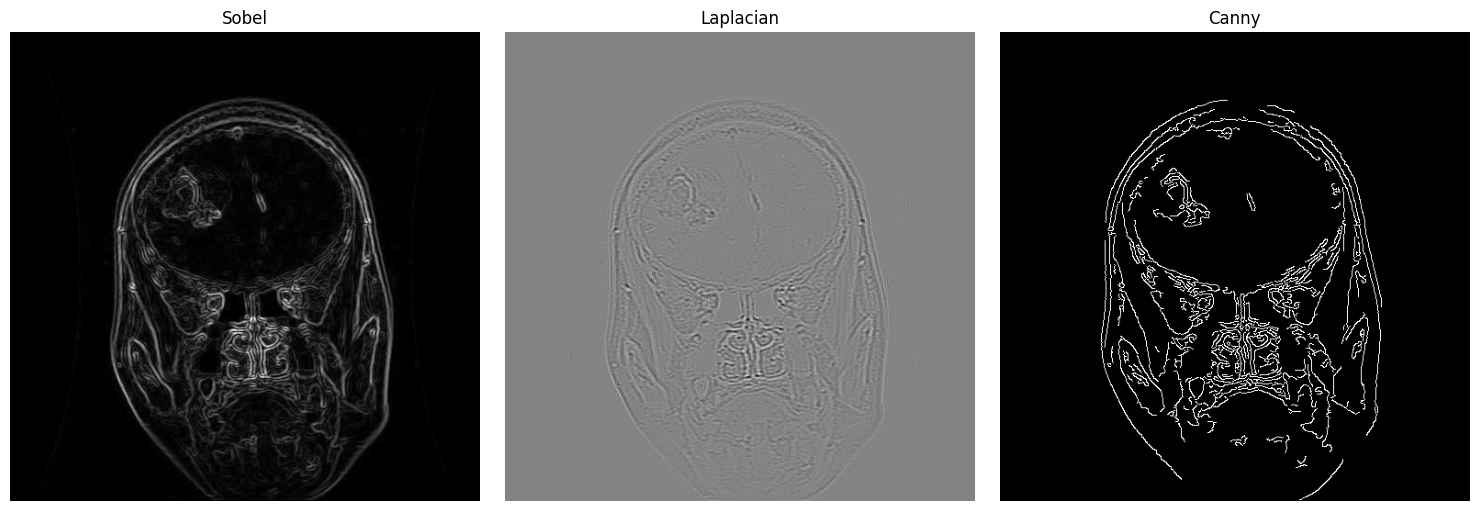

In [10]:
import cv2
import matplotlib.pyplot as plt

image_path = "D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training\glioma\Tr-glTr_0000.jpg"

# Läs bilden
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

coeffs = pywt.mra2(img, wavelet='db2', level=3)


# 1. Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
edges_sobel = cv2.magnitude(sobelx, sobely)

# 2. Laplacian
edges_lap = cv2.Laplacian(img, cv2.CV_64F)

# 3. Canny (mest klassisk)
edges_canny = cv2.Canny(img, 100, 200)

# Visa resultat
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(edges_sobel, cmap='gray'); axs[0].set_title("Sobel")
axs[1].imshow(edges_lap, cmap='gray');   axs[1].set_title("Laplacian")
axs[2].imshow(edges_canny, cmap='gray'); axs[2].set_title("Canny")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()


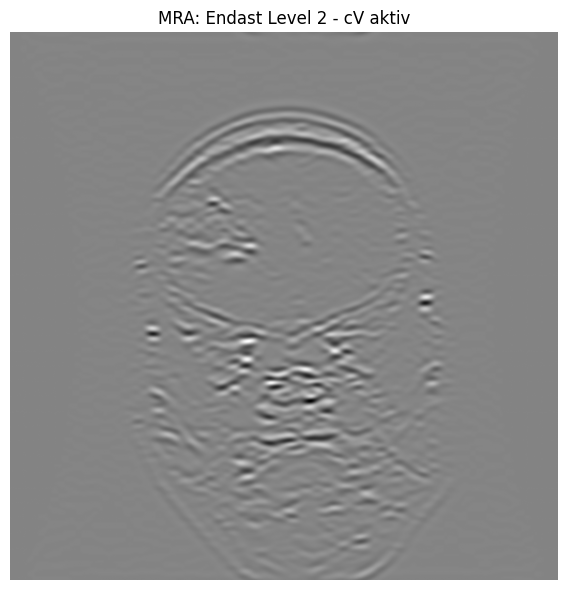

In [25]:
# Vi använder tidigare MRA-koefficienter för originalbilden
coeffs = pywt.mra2(img, wavelet='db2', level=3)

# Funktion för att nollställa alla nivåer utom en vald
def isolate_mra_component(coeffs, level_to_keep, band_to_keep):
    """
    Isolera endast en specifik komponent (t.ex. Level 2, cV) från MRA-koefficienterna.
    Övriga nivåer och band sätts till noll.
    """
    isolated = [np.zeros_like(coeffs[0])]  # A3 nollas

    for i, d in enumerate(coeffs[1:], start=1):
        if i == level_to_keep:
            # Behåll endast ett band på den nivån
            bands = {
                'cH': (d[0], np.zeros_like(d[1]), np.zeros_like(d[2])),
                'cV': (np.zeros_like(d[0]), d[1], np.zeros_like(d[2])),
                'cD': (np.zeros_like(d[0]), np.zeros_like(d[1]), d[2]),
            }
            isolated.append(bands[band_to_keep])
        else:
            isolated.append(tuple(np.zeros_like(b) for b in d))
    return isolated

# Exempel: behåll endast nivå 2, vertikal komponent (cV)
component = isolate_mra_component(coeffs, level_to_keep=1, band_to_keep='cH')

# Rekonstruera endast från denna komponent
reconstructed = pywt.imra2(component)

# Visa resultat
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap='gray')
plt.title("MRA: Endast Level 2 - cV aktiv")
plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
pywt.imra2(coeffs)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 512))

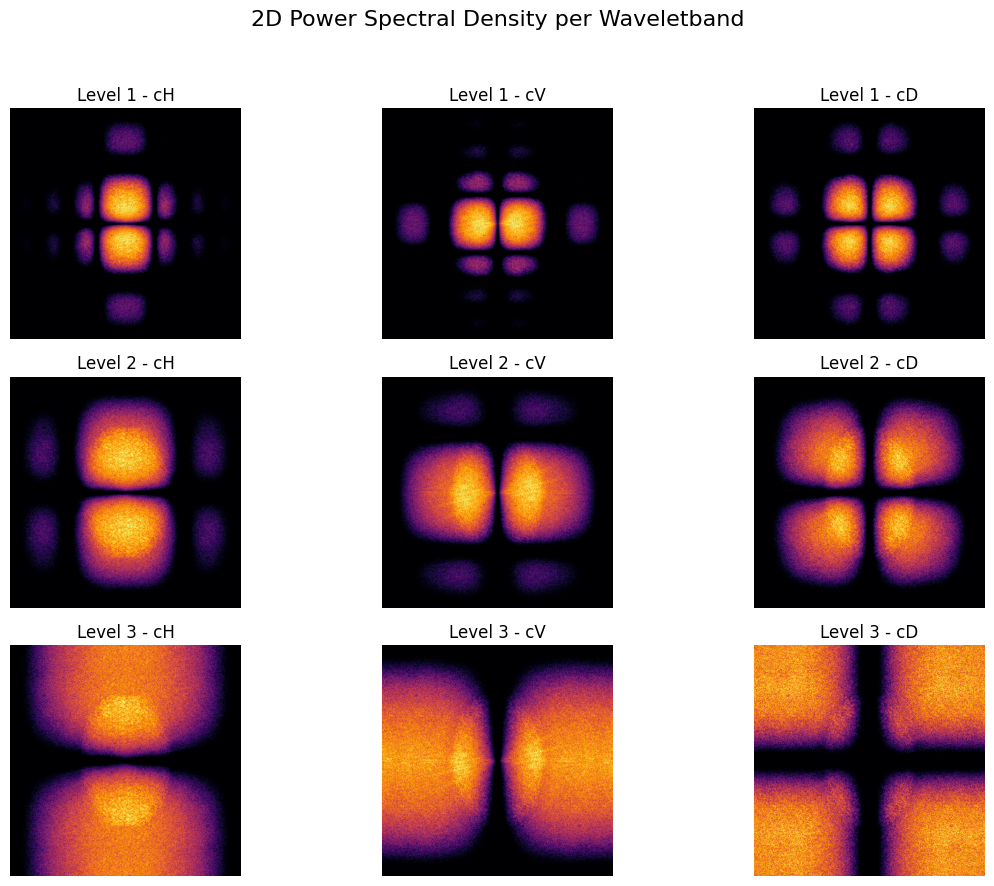

In [26]:
from scipy.fftpack import fft2, fftshift

# Funktion för att beräkna 2D Power Spectral Density från ett waveletband
def compute_2d_psd(band):
    F = fft2(band)
    Fshift = fftshift(F)
    psd2d = np.abs(Fshift)**2
    return psd2d

# Hämta waveletbandsdata från MRA för varje nivå och riktning
bands = []
labels = []

for level, (cH, cV, cD) in enumerate(coeffs[1:], start=1):
    for band, name in zip([cH, cV, cD], ['cH', 'cV', 'cD']):
        psd = compute_2d_psd(band)
        bands.append(psd)
        labels.append(f"Level {level} - {name}")

# Plotta som 3x3 rutor: PSD per band
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(np.log1p(bands[i]), cmap='inferno')  # log-skalad PSD
    ax.set_title(labels[i])
    ax.axis('off')

plt.suptitle("2D Power Spectral Density per Waveletband", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


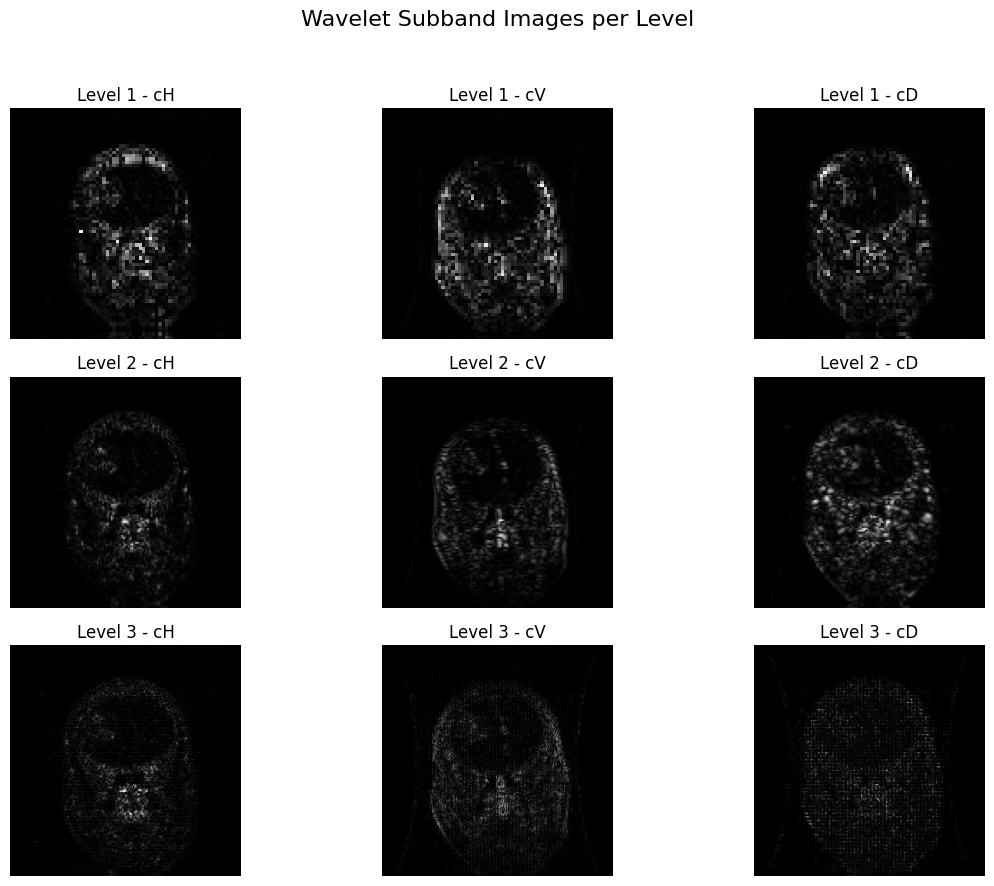

In [31]:
# Välj en bild

# Decomposition med wavedec2
coeffs = pywt.wavedec2(img, wavelet='db4', level=3)

# Extrahera alla band från nivå 1–3
bands = []
labels = []

for level, (cH, cV, cD) in enumerate(coeffs[1:], start=1):
    for band, name in zip([cH, cV, cD], ['cH', 'cV', 'cD']):
        bands.append(np.abs(band))  # ta absolutvärde för tydligare visualisering
        labels.append(f"Level {level} - {name}")

# Plotta alla bandbilder
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(bands[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis('off')

plt.suptitle("Wavelet Subband Images per Level", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


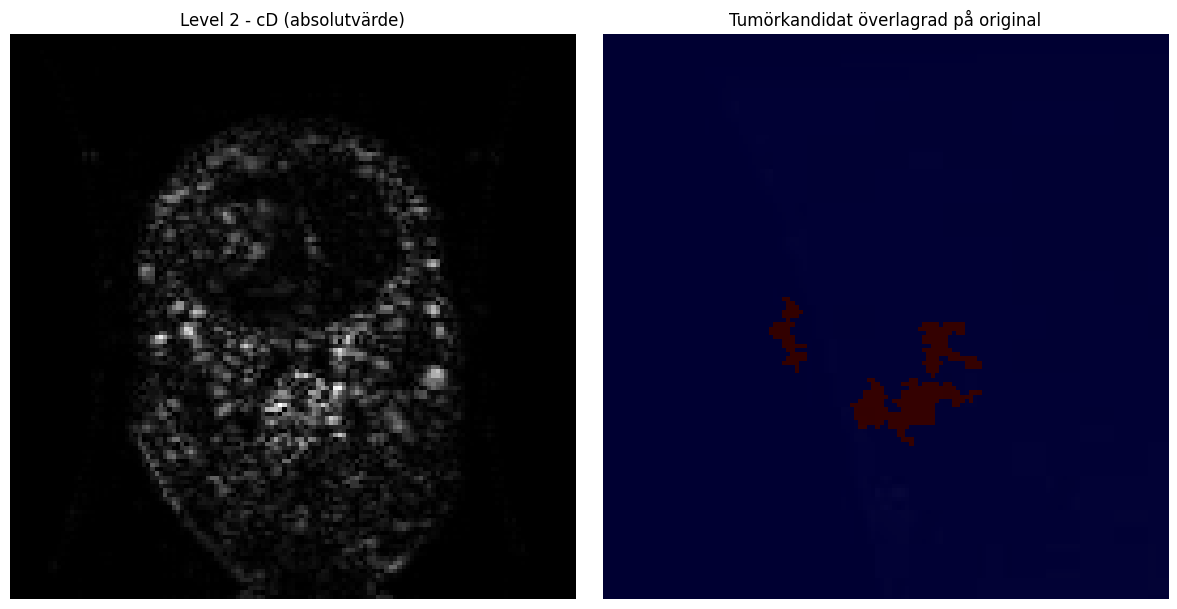

In [32]:
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_fill_holes

# Välj subband: t.ex. Level 2 - cD (diagonala detaljer, mellanskala)
level = 2
band_type = 2  # 0=cH, 1=cV, 2=cD
selected_band = np.abs(coeffs[level][band_type])

# Steg 1: Thresholda med Otsu
threshold_value = threshold_otsu(selected_band)
binary_mask = selected_band > threshold_value

# Steg 2: Postprocessing (ta bort små fläckar, fyll hål)
cleaned_mask = remove_small_objects(binary_mask, min_size=50)
cleaned_mask = binary_fill_holes(cleaned_mask)

# Visualisering
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(selected_band, cmap='gray')
axs[0].set_title("Level 2 - cD (absolutvärde)")
axs[0].axis('off')

axs[1].imshow(img, cmap='gray')
axs[1].imshow(cleaned_mask, cmap='jet', alpha=0.4)
axs[1].set_title("Tumörkandidat överlagrad på original")
axs[1].axis('off')

plt.tight_layout()
plt.show()


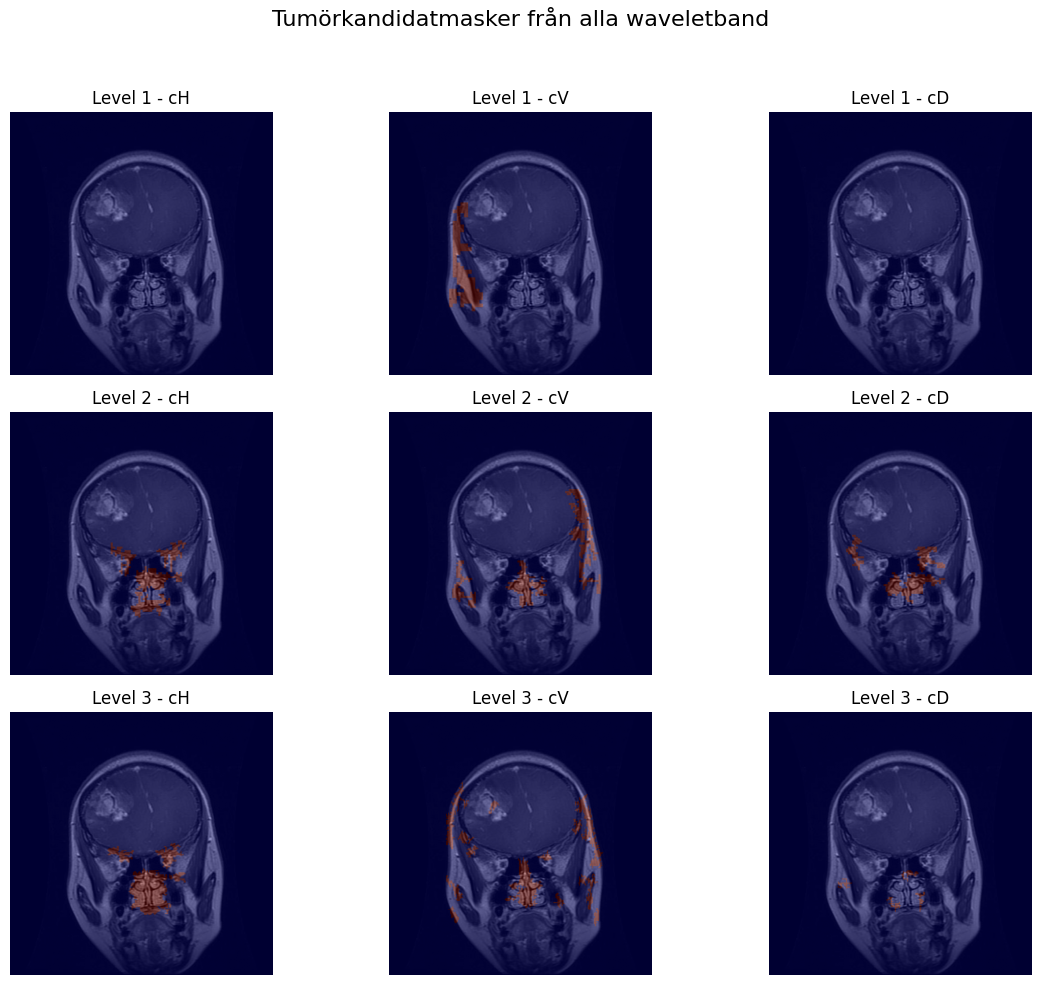

In [33]:
# Funktion: extrahera tumörkandidatmasker från alla subband (nivå 1–3, cH/cV/cD)
def extract_tumor_candidates_all_bands(coeffs, img_shape):
    masks = []
    band_labels = []

    for level, (cH, cV, cD) in enumerate(coeffs[1:], start=1):
        for band, name in zip([cH, cV, cD], ['cH', 'cV', 'cD']):
            # 1. Absolutvärde och Otsu-tröskling
            band_abs = np.abs(band)
            threshold_val = threshold_otsu(band_abs)
            binary = band_abs > threshold_val

            # 2. Postprocessing
            mask = remove_small_objects(binary, min_size=50)
            mask = binary_fill_holes(mask)

            # 3. Resiza till originalbildens storlek
            resized_mask = resize(mask, img_shape, preserve_range=True) > 0.3

            masks.append(resized_mask)
            band_labels.append(f"Level {level} - {name}")

    return masks, band_labels

# Applicera på aktuell bild
all_masks, all_labels = extract_tumor_candidates_all_bands(coeffs, img.shape)

# Visualisera alla överlagrade masker (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(img, cmap='gray')
    ax.imshow(all_masks[i], cmap='jet', alpha=0.4)
    ax.set_title(all_labels[i])
    ax.axis('off')

plt.suptitle("Tumörkandidatmasker från alla waveletband", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [2]:
import os
import cv2
import numpy as np
import pywt
from sklearn.manifold import SpectralEmbedding
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import os
import cv2
import numpy as np
import pywt

def load_and_wavelet(base_path, size=(512, 512)):
    
    features = []
    labels = []
    label_map = {"glioma": 0, "meningioma": 1, "pituitary": 2, "notumor": 3}

    for label_name, label_id in label_map.items():
        folder = os.path.join(base_path, label_name)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, size)

            # Wavelet decomposition
            coeffs = pywt.wavedec2(img, wavelet='db4', level=3)
            feature_vector = []
            for detail_level in coeffs[1:]:
                cH, cV, cD = detail_level
                for band in [cH, cV, cD]:
                    feature_vector.extend([
                        np.mean(band),
                        np.std(band),
                        np.sum(np.square(band)),   # energy
                        np.percentile(band, 75),   # upper quantile
                    ])
            features.append(feature_vector)
            labels.append(label_id)

    return np.array(features), np.array(labels)


In [3]:
X_train, y_train = load_and_wavelet(r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training")

In [4]:
X_train

array([[-7.54914137e-01,  3.47137451e+01,  5.90750857e+06, ...,
         6.16378599e-01,  2.54855866e+04,  4.20250606e-02],
       [ 1.59047079e-01,  3.08483797e+01,  4.66307435e+06, ...,
         6.10021076e-01,  2.49625831e+04,  8.40958927e-02],
       [-3.11384025e-02,  3.90002427e+01,  7.45299750e+06, ...,
         6.54937461e-01,  2.87739363e+04,  9.33234248e-02],
       ...,
       [ 1.50096896e-01,  4.62274800e+01,  1.04713119e+07, ...,
         3.37786639e-01,  7.65395367e+03,  6.35794299e-02],
       [ 2.11022161e+00,  1.02475172e+02,  5.14775082e+07, ...,
         5.15273186e-01,  1.78105368e+04,  1.77929015e-01],
       [-6.34144205e-01,  3.71994887e+01,  6.78260007e+06, ...,
         3.00112217e-01,  6.04192515e+03,  8.11792114e-02]],
      shape=(5712, 36))

In [5]:
y_train

array([0, 0, 0, ..., 3, 3, 3], shape=(5712,))

In [6]:
data_path = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"

In [7]:
X_test, y_test= load_and_wavelet(r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing")

In [68]:
y_test

array([0, 0, 0, ..., 3, 3, 3], shape=(1311,))

In [69]:
X_test

array([[-3.22484818e-01,  3.65495540e+01,  6.54627210e+06, ...,
         8.42225956e-01,  4.75836886e+04,  7.06374529e-02],
       [-1.06658100e-02,  2.17995067e+01,  2.32857116e+06, ...,
         5.83036058e-01,  2.28029473e+04,  2.79437129e-02],
       [ 1.82989634e-01,  2.23067328e+01,  2.43835669e+06, ...,
         3.89496175e-01,  1.01767222e+04,  2.38524478e-18],
       ...,
       [ 7.48016016e-02,  4.12578742e+01,  8.34086711e+06, ...,
         3.90165431e-01,  1.02116962e+04,  3.40157689e-02],
       [-3.67972977e-01,  6.98363489e+01,  2.38985300e+07, ...,
         6.15647600e-01,  2.54251732e+04,  0.00000000e+00],
       [ 1.83549628e-01,  3.09074185e+01,  4.68098081e+06, ...,
         2.41610182e-01,  3.91593275e+03,  8.29691434e-19]],
      shape=(1311, 36))

In [52]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Enhet: GPU om tillgänglig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Använder enhet:", device)

# VGG16 utan classifier (bara convolutional layers)
vgg = models.vgg16(pretrained=True).features.to(device).eval()

# Transformation för att passa VGG
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Extrahera features från EN bild
def extract_features_pytorch(img_path):
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = vgg(img_tensor)
    return features.cpu().numpy().flatten()

# Extrahera CNN-features från ALLA bilder
def extract_cnn_features(data_path, label_map):
    features = []
    labels = []
    for label_name, label_id in label_map.items():
        folder = os.path.join(data_path, label_name)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            try:
                feat = extract_features_pytorch(img_path)
                features.append(feat)
                labels.append(label_id)
            except Exception as e:
                print(f"Fel med {img_path}: {e}")
                continue
    return np.array(features), np.array(labels)


Använder enhet: cuda


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
import os
import torch
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


vgg = vgg16(weights=VGG16_Weights.DEFAULT)


# Enhet: GPU om tillgänglig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Använder enhet:", device)

# VGG16 utan classifier (bara convolutional layers)
vgg = vgg16(weights=VGG16_Weights.DEFAULT)

# Transformation för att passa VGG
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Extrahera features från EN bild
def extract_features_pytorch(img_path):
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = vgg(img_tensor)
    return features.cpu().numpy().flatten()

# Extrahera CNN-features från ALLA bilder
def extract_cnn_features(data_path, label_map):
    features = []
    labels = []
    for label_name, label_id in label_map.items():
        folder = os.path.join(data_path, label_name)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            try:
                feat = extract_features_pytorch(img_path)
                features.append(feat)
                labels.append(label_id)
            except Exception as e:
                print(f"Fel med {img_path}: {e}")
                continue
    return np.array(features), np.array(labels)


Använder enhet: cuda


In [56]:
import os
import torch
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# 1. Enhet: GPU om tillgänglig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Använder enhet:", device)

# 2. Ladda VGG16 med moderna weights
vgg = vgg16(weights=VGG16_Weights.DEFAULT).to(device).eval()

# 3. Transformation för VGG16
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet-standard
        std=[0.229, 0.224, 0.225]
    )
])

# 4. Extrahera features från EN bild
def extract_features_pytorch(img_path):
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)

    with torch.no_grad():
        # Använd endast convolution + pooling (ej classifier)
        conv_feats = vgg.features(img_tensor)       # shape: (1, 512, 7, 7)
        pooled_feats = vgg.avgpool(conv_feats)      # shape: (1, 512, 7, 7)
        flat_feats = torch.flatten(pooled_feats, 1) # shape: (1, 25088)
    
    return flat_feats.cpu().numpy().flatten()       # shape: (25088,)

# 5. Extrahera CNN-features från ALLA bilder i datamapp
def extract_cnn_features(data_path, label_map):
    features = []
    labels = []

    for label_name, label_id in label_map.items():
        folder = os.path.join(data_path, label_name)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            try:
                feat = extract_features_pytorch(img_path)
                features.append(feat)
                labels.append(label_id)
            except Exception as e:
                print(f"❌ Fel med {img_path}: {e}")
                continue

    return np.array(features), np.array(labels)


Använder enhet: cuda


In [8]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms

# Enhet: GPU om tillgänglig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Använder enhet:", device)

# VGG16 utan classifier
vgg = vgg16(weights=VGG16_Weights.DEFAULT).to(device).eval()

# Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Custom Dataset
class BrainDataset(Dataset):
    def __init__(self, base_path, label_map, transform):
        self.paths = []
        self.labels = []
        self.transform = transform

        for label_name, label_id in label_map.items():
            folder = os.path.join(base_path, label_name)
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                self.paths.append(img_path)
                self.labels.append(label_id)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Batch-feature extraction
def extract_cnn_features_batched(data_path, label_map, batch_size=64):
    dataset = BrainDataset(data_path, label_map, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_features = []
    all_labels = []

    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            conv_feats = vgg.features(batch_imgs)
            pooled_feats = vgg.avgpool(conv_feats)
            flat_feats = torch.flatten(pooled_feats, 1)
            all_features.append(flat_feats.cpu().numpy())
            all_labels.extend(batch_labels.numpy())

    X = np.concatenate(all_features, axis=0)
    y = np.array(all_labels)
    return X, y


Använder enhet: cuda


In [9]:
X_train.shape

(5712, 36)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.290196084391837].


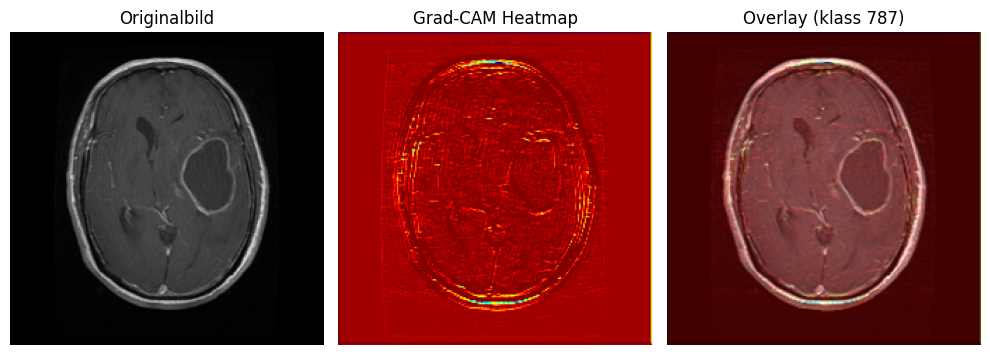

In [47]:
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16(weights=VGG16_Weights.DEFAULT).to(device).eval()

# Transformation (samma som i din pipeline)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# --- Grad-CAM-klass ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        handle_fw = self.target_layer.register_forward_hook(forward_hook)
        handle_bw = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([handle_fw, handle_bw])

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_index=None):
        output = self.model(input_tensor)

        if class_index is None:
            class_index = torch.argmax(output)

        self.model.zero_grad()
        output[0, class_index].backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        grad_cam = torch.relu(torch.sum(weights * self.activations, dim=1)).squeeze()

        grad_cam = grad_cam.cpu().numpy()
        grad_cam = cv2.resize(grad_cam, (224, 224))
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)
        return grad_cam, class_index.item()

# --- Bildinläsning & Grad-CAM-användning ---
img_path = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training\glioma\Tr-gl_0125.jpg"  # <-- byt till riktig bild
orig_img = Image.open(img_path).convert('RGB')
input_tensor = transform(orig_img).unsqueeze(0).to(device)

target_layer = model.features[2]  # sista conv-layer i VGG16
grad_cam = GradCAM(model, target_layer)
cam, predicted_class = grad_cam.generate(input_tensor)

# --- Visualisering ---
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

img_np = np.array(orig_img.resize((224, 224))) / 255.0
overlay = heatmap * 0.4 + img_np

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Originalbild")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (klass {predicted_class})")
plt.axis("off")
plt.tight_layout()
plt.show()

grad_cam.remove_hooks()


In [65]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

# 💡 Ladda dataset utan Normalize först
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 📁 Byt sökväg till din mapp med bilder
dataset = ImageFolder(root="D:/Programmering/Kraggle/Parvar_brain-tumor-mri-dataset/Training", transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# 🔢 Beräkna mean & std
mean = 0.0
std = 0.0
nb_samples = 0

for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Dataset mean: {mean.item():.4f}, std: {std.item():.4f}")


Dataset mean: 0.1855, std: 0.1813


In [71]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 🔧 Enhet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Sökvägar
train_dir = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"
val_dir = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing"

# 🧠 Modell: Ladda VGG16 och anpassa till gråskala
model = vgg16(weights=VGG16_Weights.DEFAULT)

# Anpassa första lagret för 1-kanals input
original_conv = model.features[0]
model.features[0] = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding
)
with torch.no_grad():
    model.features[0].weight[:] = original_conv.weight.mean(dim=1, keepdim=True)

# Anpassa classifier för 4 klasser
model.classifier[6] = nn.Linear(4096, 4)
model = model.to(device)

# 📐 Transformationer
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1813], std=[0.1813])  # Din dataset-mean/std
])

# 📂 Dataset & Dataloader
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# 🎯 Förlust och optimerare
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


In [72]:
for epoch in range(5):  # öka till t.ex. 15 för bättre resultat
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 154.9407
Epoch 2 | Loss: 74.2824


KeyboardInterrupt: 

In [73]:
import time

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Framåt + bakåt + optimering
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {time.time() - start_time:.1f}s")

        # --- Validering ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total * 100
        print(f"  🔎 Validering | Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")



In [74]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=9)

Epoch 1/10 | Loss: 0.2904 | Acc: 89.81% | Time: 107.5s
  🔎 Validering | Loss: 0.3490 | Acc: 86.27%
Epoch 2/10 | Loss: 0.2379 | Acc: 91.21% | Time: 134.8s
  🔎 Validering | Loss: 0.2534 | Acc: 90.08%
Epoch 3/10 | Loss: 0.2022 | Acc: 92.56% | Time: 129.5s
  🔎 Validering | Loss: 0.2405 | Acc: 90.77%
Epoch 4/10 | Loss: 0.1737 | Acc: 93.56% | Time: 130.0s
  🔎 Validering | Loss: 0.1996 | Acc: 92.60%
Epoch 5/10 | Loss: 0.1500 | Acc: 94.52% | Time: 128.5s
  🔎 Validering | Loss: 0.1767 | Acc: 93.06%
Epoch 6/10 | Loss: 0.1273 | Acc: 95.29% | Time: 125.1s
  🔎 Validering | Loss: 0.1515 | Acc: 94.36%
Epoch 7/10 | Loss: 0.1068 | Acc: 96.15% | Time: 129.6s
  🔎 Validering | Loss: 0.2131 | Acc: 92.45%
Epoch 8/10 | Loss: 0.1002 | Acc: 96.18% | Time: 130.8s
  🔎 Validering | Loss: 0.1210 | Acc: 95.19%
Epoch 9/10 | Loss: 0.0808 | Acc: 97.08% | Time: 128.3s
  🔎 Validering | Loss: 0.1018 | Acc: 96.72%
Epoch 10/10 | Loss: 0.0764 | Acc: 97.16% | Time: 129.3s
  🔎 Validering | Loss: 0.1578 | Acc: 94.05%


In [75]:
# 🔐 Spara modellen
torch.save(model.state_dict(), "brain_tumor_model.pth")
print("✅ Modellen sparad som brain_tumor_model.pth")

✅ Modellen sparad som brain_tumor_model.pth


In [77]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 4))
plt.plot(train.loss, label="Träning")
plt.plot(val_loss, label="Validering")
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_acc, label="Träning")
plt.plot(val_acc, label="Validering")
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'function' object has no attribute 'loss'

<Figure size 1000x400 with 0 Axes>

In [78]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("📊 Klassificeringsrapport:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))


📊 Klassificeringsrapport:
              precision    recall  f1-score   support

      glioma       1.00      0.87      0.93       300
  meningioma       0.81      0.97      0.89       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.99      0.92      0.95       300

    accuracy                           0.94      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



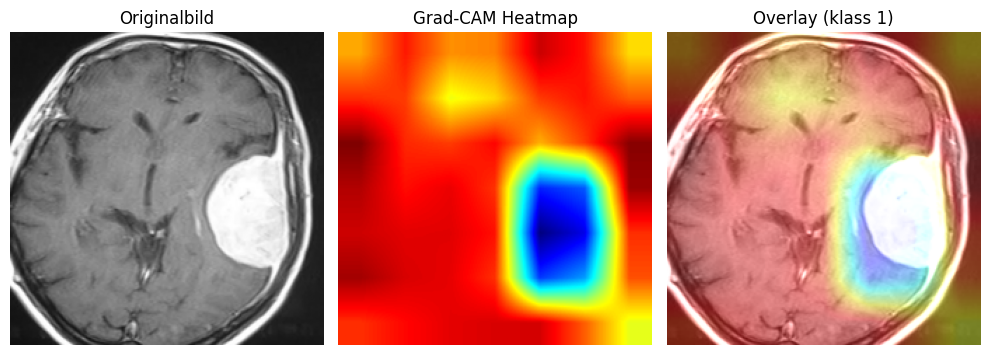

In [91]:
# target_layer = sista conv-lagret i VGG16 (oförändrat)
target_layer = model.features[30]
grad_cam = GradCAM(model, target_layer)

# Ladda en bild från din dataset
img_path = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing\meningioma\Te-me_0012.jpg"
orig_img = Image.open(img_path).convert('RGB')
input_tensor = transform(orig_img).unsqueeze(0).to(device)

# 🔥 Generera Grad-CAM
cam, predicted_class = grad_cam.generate(input_tensor)

# 📊 Visualisering (som innan)
# --- Visualisering ---
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

img_np = np.array(orig_img.resize((224, 224))) / 255.0
overlay = np.clip(overlay, 0, 1)  # fixar värden över 1.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Originalbild")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (klass {predicted_class})")
plt.axis("off")
plt.tight_layout()
plt.show()

grad_cam.remove_hooks()


In [98]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Feature-hållare ---
feature_maps = []

def hook_fn(module, input, output):
    flat = output.view(output.size(0), -1)  # [N, 25088]
    feature_maps.append(flat.detach().cpu())

# --- Koppla hook till sista conv-lagret (t.ex. features[30]) ---
target_layer = model.features[30]
hook_handle = target_layer.register_forward_hook(hook_fn)

# --- Extrahera features från val_loader ---
model.eval()
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        _ = model(images)  # hook_fn körs automatiskt
        all_labels.extend(labels.cpu().numpy())

# --- Sammanfoga och konvertera till numpy ---
features = torch.cat(feature_maps, dim=0).numpy()
labels = np.array(all_labels)


100%|█████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.38it/s]


RuntimeError: Tensors must have same number of dimensions: got 4 and 2

Extracting features: 100%|████████████████████████████████████| 41/41 [00:04<00:00,  8.23it/s]


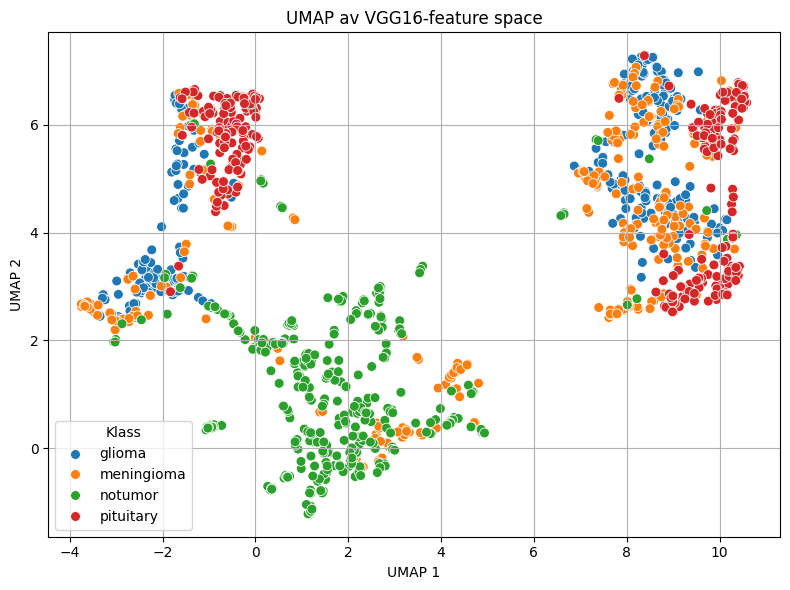

In [102]:
# --- Hämta klassnamn för etiketter ---
class_names = val_data.classes  # t.ex. ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# --- Hook på ett stabilt lager: classifier[0] (ger [N, 4096]) ---
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach().cpu())

hook_handle = model.classifier[0].register_forward_hook(hook_fn)

# --- Extrahera features från val_loader ---
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

model.eval()
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Extracting features"):
        images = images.to(device)
        _ = model(images)
        all_labels.extend(labels.cpu().numpy())

# --- Sammanfoga features ---
features = torch.cat(feature_maps, dim=0).numpy()
labels = np.array(all_labels)

# --- Ta bort hook ---
hook_handle.remove()



C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


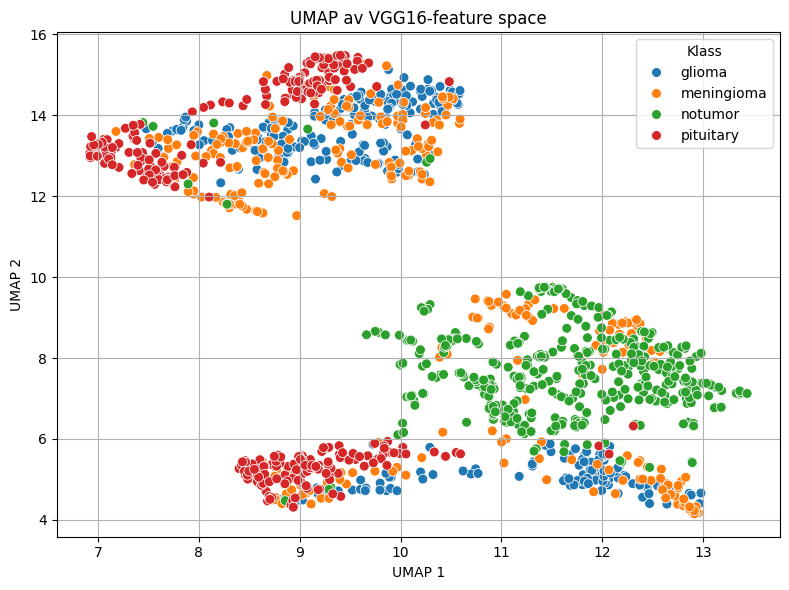

In [109]:
# --- UMAP till 2D ---
umap_model = umap.UMAP(n_components=2, n_neighbors=70, random_state=42)
embedding = umap_model.fit_transform(features)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1],
    hue=[class_names[i] for i in labels],
    palette='tab10', s=50
)
plt.title("UMAP av VGG16-feature space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Klass")
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
from umap import UMAP
import pandas as pd

umap_supervised = UMAP(n_components=2, n_neighbors=70, random_state=42)
X_umap_train = umap_supervised.fit_transform(X_cnn_train, y_cnn_train)
X_umap_test = umap_supervised.transform(X_cnn_test)

# Kombinera för plotting
X_both = np.vstack([X_umap_train, X_umap_test])
y_both = np.hstack([y_cnn_train, y_cnn_test])
split = ['Train'] * len(y_cnn_train) + ['Test'] * len(y_cnn_test)

df_umap = pd.DataFrame(X_both, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = [class_names[i] for i in y_both]
df_umap['Split'] = split


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


SystemError: CPUDispatcher(<function nn_descent at 0x000001CA2B1CDBC0>) returned a result with an exception set

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Label', style='Split', palette='tab10', s=60)
plt.title('Supervised UMAP – Train vs Test (CNN features)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.legend(title="Klass / Split")
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf_svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
clf_svm.fit(X_umap_train, y_cnn_train)
y_pred_svm = clf_svm.predict(X_umap_test)

print("🔹 SVM Resultat (supervised UMAP):")
print(classification_report(y_cnn_test, y_pred_svm, target_names=class_names))


🔹 SVM Resultat (supervised UMAP):
              precision    recall  f1-score   support

      glioma       0.71      0.91      0.80       300
  meningioma       0.89      0.60      0.72       306
     notumor       0.84      0.95      0.90       300
   pituitary       0.99      0.93      0.96       405

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.84      1311
weighted avg       0.87      0.86      0.85      1311



In [112]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf_xgb.fit(X_umap_train, y_cnn_train)
y_pred_xgb = clf_xgb.predict(X_umap_test)

print("🔸 XGBoost Resultat (supervised UMAP):")
print(classification_report(y_cnn_test, y_pred_xgb, target_names=class_names))


🔸 XGBoost Resultat (supervised UMAP):
              precision    recall  f1-score   support

      glioma       0.75      0.86      0.80       300
  meningioma       0.87      0.63      0.73       306
     notumor       0.89      0.94      0.92       300
   pituitary       0.92      0.99      0.95       405

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.87      0.86      0.86      1311



C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [100]:
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ✅ Aktivera GPU om möjligt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Ladda din färdigtränade VGG16-modell
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

model = vgg16(weights=VGG16_Weights.DEFAULT)

# Anpassningar för din modell
model.features[0] = nn.Conv2d(
    1, 64, kernel_size=3, stride=1, padding=1
)
with torch.no_grad():
    model.features[0].weight[:] = model.features[0].weight.mean(dim=1, keepdim=True)

model.classifier[6] = nn.Linear(4096, 4)
model = model.to(device)

# ✅ Ladda tränade vikter om du har dem sparade
# model.load_state_dict(torch.load("din_model.pth"))

model.eval()

feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach().cpu())

# 📌 Hook på första dense-lagret (4096-dim)
hook_handle = model.classifier[0].register_forward_hook(hook_fn)

# 🧪 Extrahera features från testdata
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        _ = model(images)
        all_labels.extend(labels.cpu().numpy())

# Slå ihop features
features = torch.cat(feature_maps, dim=0).numpy()
labels = np.array(all_labels)

# Ta bort hook
hook_handle.remove()


100%|█████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.37it/s]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Mappa etiketter
label_map = {"glioma": 0, "meningioma": 1, "pituitary": 2, "notumor": 3}
data_train = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"
data_test = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing"

# Extrahera features
X_wavelet_train, y_wavelet_train = X_train, y_train
X_wavelet_test, y_wavelet_test = X_test, y_test

# Extrahera CNN-features
X_cnn_train, y_cnn_train = extract_cnn_features_batched(data_train, label_map)
X_cnn_test, y_cnn_test = extract_cnn_features_batched(data_test, label_map)

# Kontrollera att etiketterna matchar
assert np.array_equal(y_wavelet_train, y_cnn_train), "Mismatch i träningsdata"
assert np.array_equal(y_wavelet_test, y_cnn_test), "Mismatch i testdata"

# Kombinera features
X_train = np.concatenate([X_wavelet_train, X_cnn_train], axis=1)
y_train = y_wavelet_train

X_test = np.concatenate([X_wavelet_test, X_cnn_test], axis=1)
y_test = y_wavelet_test

# Träna och testa modellen
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.82      0.89       300
           1       0.83      0.88      0.85       306
           2       0.92      0.97      0.94       300
           3       0.98      1.00      0.99       405

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Mappa etiketter
label_map = {"glioma": 0, "meningioma": 1, "pituitary": 2, "notumor": 3}
data_train = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"
data_test = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing"

# Extrahera features
X_wavelet_train, y_wavelet_train = X_train, y_train
X_wavelet_test, y_wavelet_test = X_test, y_test

# Extrahera CNN-features
X_cnn_train, y_cnn_train = extract_cnn_features_batched(data_train, label_map)
X_cnn_test, y_cnn_test = extract_cnn_features_batched(data_test, label_map)

# Kontrollera att etiketterna matchar
#assert np.array_equal(y_wavelet_train, y_cnn_train), "Mismatch i träningsdata"
#assert np.array_equal(y_wavelet_test, y_cnn_test), "Mismatch i testdata"

# Kombinera features
#X_train = np.concatenate([X_wavelet_train, X_cnn_train], axis=1)
#y_train = y_wavelet_train

# Träna och testa modellen
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_cnn_train, y_cnn_train)

y_pred = clf.predict(X_cnn_test)
print(classification_report(y_cnn_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       300
           1       0.82      0.86      0.84       306
           2       0.91      0.96      0.94       300
           3       0.98      1.00      0.99       405

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Mappa etiketter
label_map = {"glioma": 0, "meningioma": 1, "pituitary": 2, "notumor": 3}
data_train = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"
data_test = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing"

# Extrahera features
X_wavelet_train, y_wavelet_train = X_train, y_train
X_wavelet_test, y_wavelet_test = X_test, y_test

# Extrahera CNN-features
X_cnn_train, y_cnn_train = extract_cnn_features_batched(data_train, label_map)
X_cnn_test, y_cnn_test = extract_cnn_features_batched(data_test, label_map)

# Kontrollera att etiketterna matchar
#assert np.array_equal(y_wavelet_train, y_cnn_train), "Mismatch i träningsdata"
#assert np.array_equal(y_wavelet_test, y_cnn_test), "Mismatch i testdata"

# Kombinera features
#X_train = np.concatenate([X_wavelet_train, X_cnn_train], axis=1)
#y_train = y_wavelet_train

# Träna och testa modellen
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_wavelet_train, y_wavelet_train)

y_pred = clf.predict(X_wavelet_test)
print(classification_report(y_wavelet_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.82      0.88       300
           1       0.83      0.88      0.85       306
           2       0.93      0.97      0.95       300
           3       0.98      1.00      0.99       405

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Mappa etiketter
label_map = {"glioma": 0, "meningioma": 1, "pituitary": 2, "notumor": 3}
data_train = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Training"
data_test = r"D:\Programmering\Kraggle\Parvar_brain-tumor-mri-dataset\Testing"

# Extrahera features
X_wavelet_train, y_wavelet_train = X_train, y_train
X_wavelet_test, y_wavelet_test = X_test, y_test

# Extrahera CNN-features
X_cnn_train, y_cnn_train = extract_cnn_features(data_train, label_map)
X_cnn_test, y_cnn_test = extract_cnn_features(data_test, label_map)

# Kontrollera att etiketterna matchar
assert np.array_equal(y_wavelet_train, y_cnn_train), "Mismatch i träningsdata"
assert np.array_equal(y_wavelet_test, y_cnn_test), "Mismatch i testdata"

# Kombinera features
X_train = np.concatenate([X_wavelet_train, X_cnn_train], axis=1)
y_train = y_wavelet_train

X_test = np.concatenate([X_wavelet_test, X_cnn_test], axis=1)
y_test = y_wavelet_test

# Träna och testa modellen
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


NameError: name 'extract_cnn_features' is not defined

array([[-3.22484818e-01,  3.65495540e+01,  6.54627210e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.06658100e-02,  2.17995067e+01,  2.32857116e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82989634e-01,  2.23067328e+01,  2.43835669e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.48016016e-02,  4.12578742e+01,  8.34086711e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.67972977e-01,  6.98363489e+01,  2.38985300e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.83549628e-01,  3.09074185e+01,  4.68098081e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(1311, 25124))

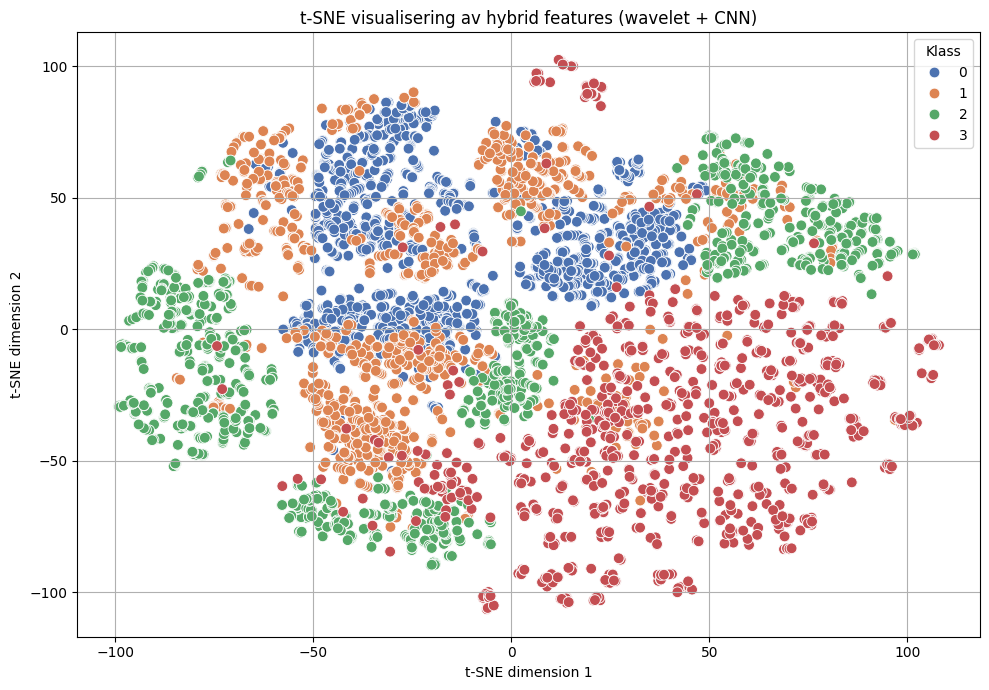

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Använd X_hybrid och y om de finns, annars generera dummy
try:
    X_vis = X_cnn_train
    y_vis = y_cnn_train
except:
    # Fallback om X_hybrid/y saknas (t.ex. efter omstart)
    from sklearn.datasets import make_classification
    X_vis, y_vis = make_classification(n_samples=300, n_features=50, n_classes=4, n_informative=20, random_state=42)

# Reducera till 2D med t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_vis)

# Plotta
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_vis, palette="deep", s=60)
plt.title("t-SNE visualisering av hybrid features (wavelet + CNN)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


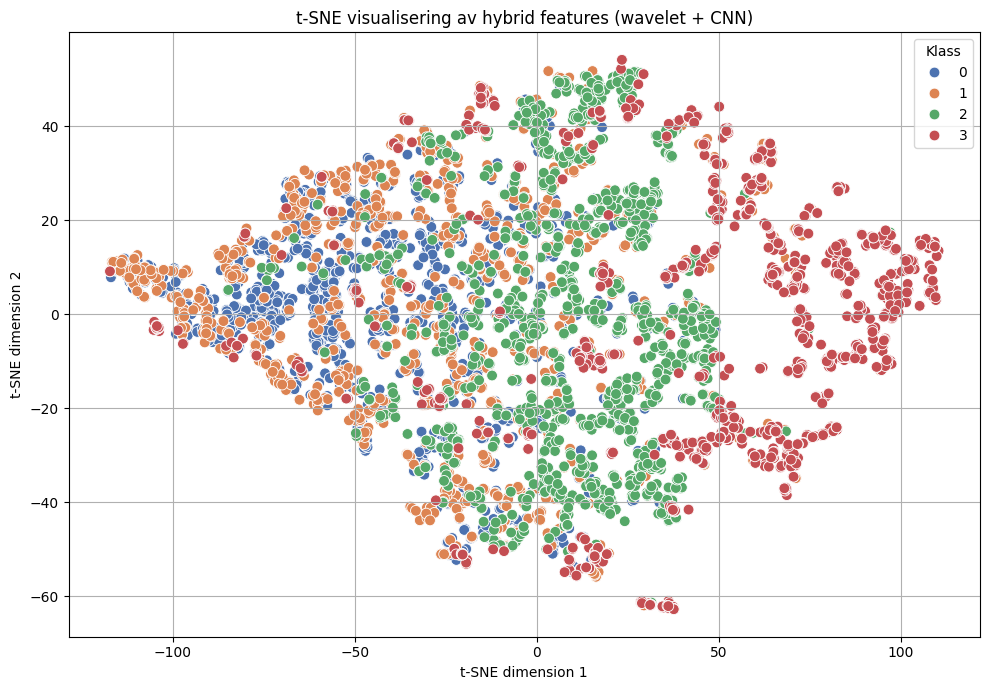

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Använd X_hybrid och y om de finns, annars generera dummy
try:
    X_vis = X_wavelet_train
    y_vis = y_wavelet_train
except:
    # Fallback om X_hybrid/y saknas (t.ex. efter omstart)
    from sklearn.datasets import make_classification
    X_vis, y_vis = make_classification(n_samples=300, n_features=50, n_classes=4, n_informative=20, random_state=42)

# Reducera till 2D med t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_vis)

# Plotta
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_vis, palette="deep", s=60)
plt.title("t-SNE visualisering av hybrid features (wavelet + CNN)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


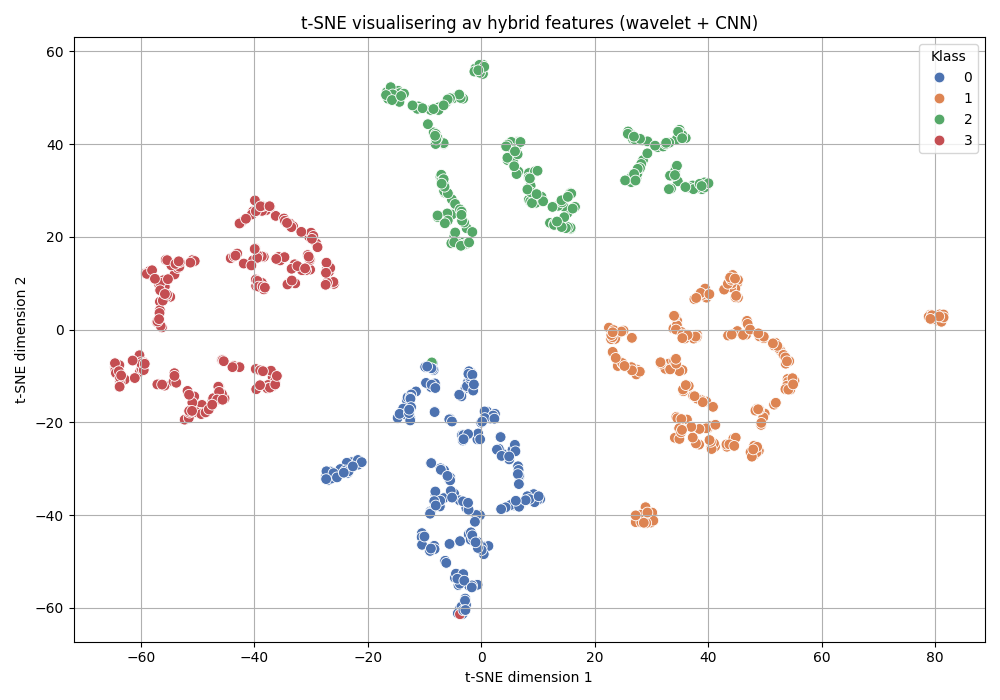

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Använd X_hybrid och y om de finns, annars generera dummy
try:
    X_vis = X_train
    y_vis = y_train
except:
    # Fallback om X_hybrid/y saknas (t.ex. efter omstart)
    from sklearn.datasets import make_classification
    X_vis, y_vis = make_classification(n_samples=300, n_features=50, n_classes=4, n_informative=20, random_state=42)

# Reducera till 2D med t-SNE
tsne = TSNE(n_components=2, perplexity=10,init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_vis)

# Plotta
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_vis, palette="deep", s=60)
plt.title("t-SNE visualisering av hybrid features (wavelet + CNN)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


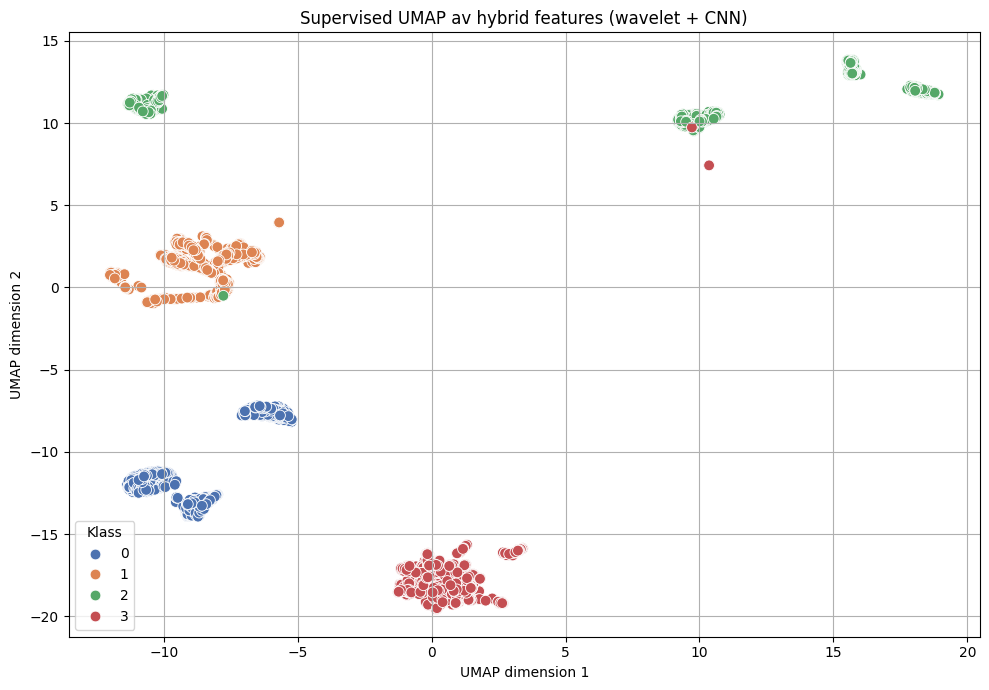

In [33]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Antag att X_train och y_train redan är laddade och innehåller hybrid features + labels

# Supervised UMAP (med y_train som target)
umap_supervised = UMAP(n_components=2, n_neighbors=70, random_state=42)
X_umap_supervised = umap_supervised.fit_transform(X_cnn_train, y_cnn_train)

# Konvertera till DataFrame för enklare hantering
df_umap = pd.DataFrame(X_umap_supervised, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = y_cnn_train

# Visualisering
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Label', palette='deep', s=60)
plt.title('Supervised UMAP av hybrid features (wavelet + CNN)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.legend(title="Klass")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


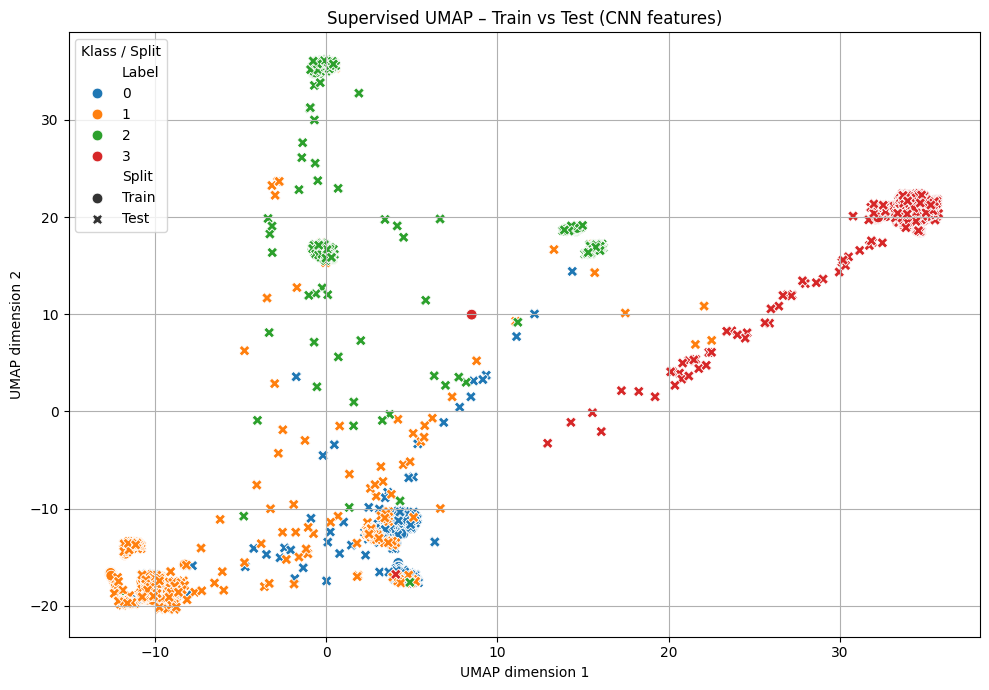

In [34]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === Antag att du redan har dessa matriser ===
# X_cnn_train, y_cnn_train
# X_cnn_test,  y_cnn_test
# Eller byt till X_train / X_test om du använder hybrid features

# Träna UMAP på träningsdata (supervised)
umap_supervised = UMAP(n_components=2, n_neighbors=200, random_state=42)
X_umap_train = umap_supervised.fit_transform(X_cnn_train, y_cnn_train)

# Transformera testdata till samma inlärda UMAP-space
X_umap_test = umap_supervised.transform(X_cnn_test)

# Kombinera train och test för visualisering
X_both = np.vstack([X_umap_train, X_umap_test])
y_both = np.hstack([y_cnn_train, y_cnn_test])
split = ['Train'] * len(y_cnn_train) + ['Test'] * len(y_cnn_test)

# Skapa DataFrame
df_umap = pd.DataFrame(X_both, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = y_both
df_umap['Split'] = split

# Visualisering
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Label', style='Split', palette='tab10', s=60)
plt.title('Supervised UMAP – Train vs Test (CNN features)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.legend(title="Klass / Split")
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
from umap import UMAP
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
import numpy as np

# 1. UMAP: Lär in på train, transformera test
umap_supervised = UMAP(n_components=2, n_neighbors=50, random_state=42)
X_train_umap = umap_supervised.fit_transform(X_cnn_train, y_cnn_train)
X_test_umap = umap_supervised.transform(X_cnn_test)

# --------- VAL 1: SVM ----------
clf_svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
clf_svm.fit(X_train_umap, y_cnn_train)
y_pred_svm = clf_svm.predict(X_test_umap)
print("🔹 SVM Resultat:")
print(classification_report(y_cnn_test, y_pred_svm))

# --------- VAL 2: XGBoost ----------
clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf_xgb.fit(X_train_umap, y_cnn_train)
y_pred_xgb = clf_xgb.predict(X_test_umap)
print("🔸 XGBoost Resultat:")
print(classification_report(y_cnn_test, y_pred_xgb))


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔹 SVM Resultat:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       300
           1       0.83      0.80      0.81       306
           2       0.88      0.96      0.92       300
           3       0.99      0.99      0.99       405

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.89      0.89      0.89      1311

🔸 XGBoost Resultat:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       300
           1       0.84      0.77      0.80       306
           2       0.92      0.95      0.93       300
           3       0.86      0.99      0.92       405

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:43:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Parametrar att testa
param_grid_svm = {
    'C': [0.1, 1, 10],                   # Regularisering
    'gamma': ['scale', 0.01, 0.001],     # Kernel-koefficient
    'kernel': ['rbf']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_svm.fit(X_train_umap, y_train)

print("Bästa parametrar för SVM:", grid_svm.best_params_)
print("Bästa accuracy (cross-val):", grid_svm.best_score_)


In [21]:
X_cnn_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.8730707, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.1496942, 1.0254035,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], shape=(5712, 25088), dtype=float32)

C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


              precision    recall  f1-score   support

           0       0.73      0.44      0.55       300
           1       0.50      0.59      0.54       306
           2       0.70      0.75      0.72       300
           3       0.83      0.91      0.87       405

    accuracy                           0.69      1311
   macro avg       0.69      0.67      0.67      1311
weighted avg       0.70      0.69      0.69      1311



C:\Users\Rando\AppData\Local\Temp\ipykernel_28908\208823918.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7))


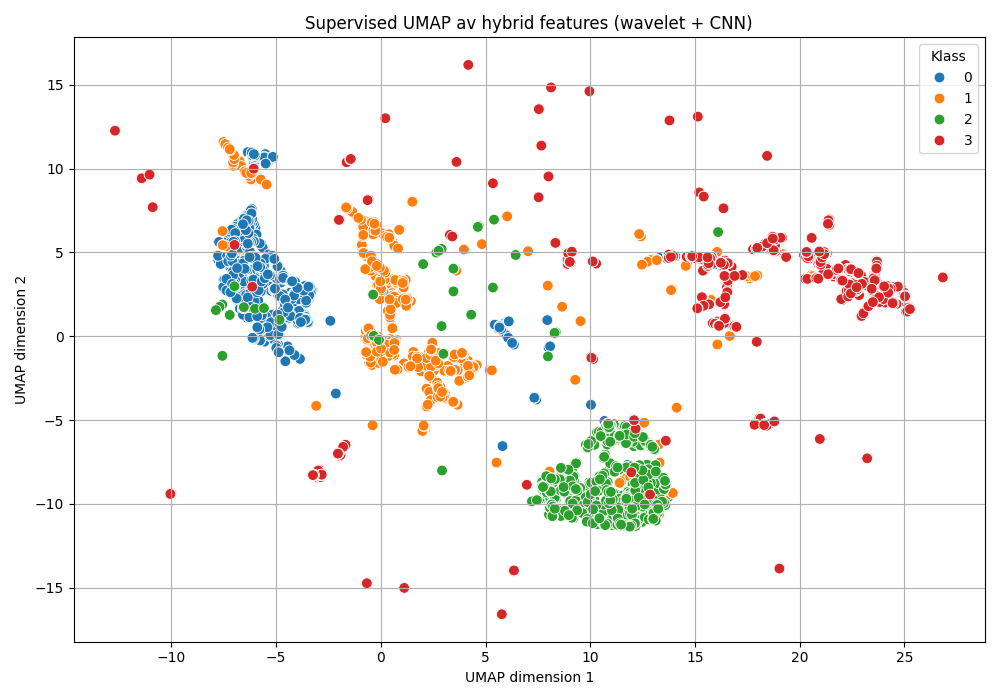

In [79]:
from umap import UMAP
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised UMAP på träningsdata
umap_model = UMAP(n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train, y_train)

# Transformera testdata med samma UMAP
X_test_umap = umap_model.transform(X_test)

# Träna SVM på UMAP-reducerade features
clf = SVC(kernel='rbf')
clf.fit(X_train_umap, y_train)

# Utvärdera
y_pred = clf.predict(X_test_umap)
print(classification_report(y_test, y_pred))

# Visualisera träningsdata (eller byt till X_test_umap om du hellre vill)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=y_train, palette="tab10", s=60)
plt.title("Supervised UMAP av hybrid features (wavelet + CNN)")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
X_train.shape


(5712, 25124)

C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


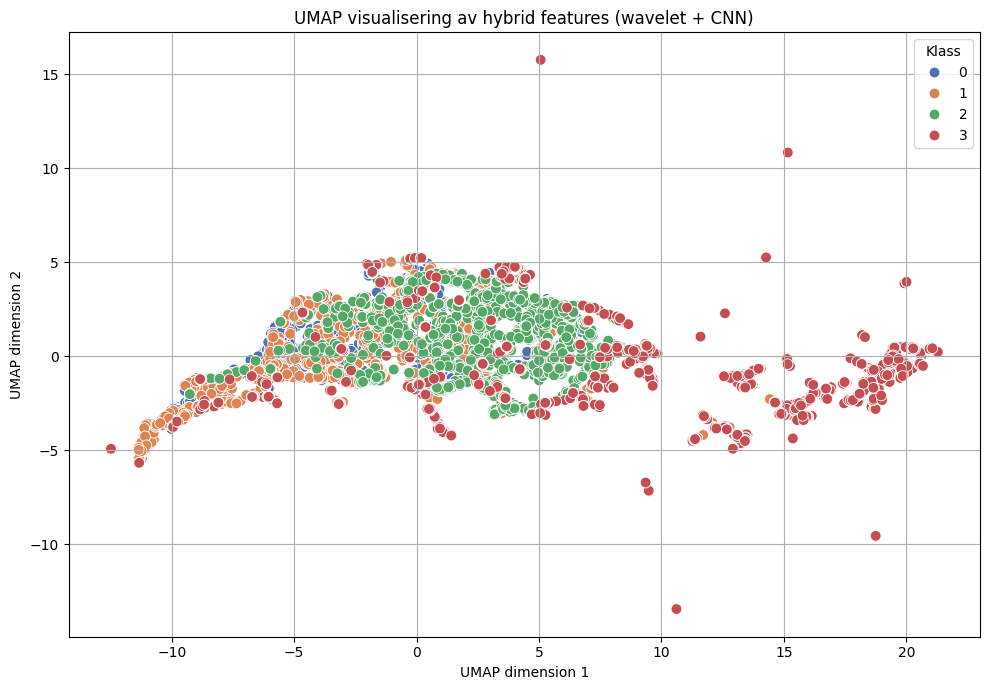

In [25]:
import umap.umap_ as umap

# Reducera till 2D med UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_vis)

# Plotta
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_vis, palette="deep", s=60)
plt.title("UMAP visualisering av hybrid features (wavelet + CNN)")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


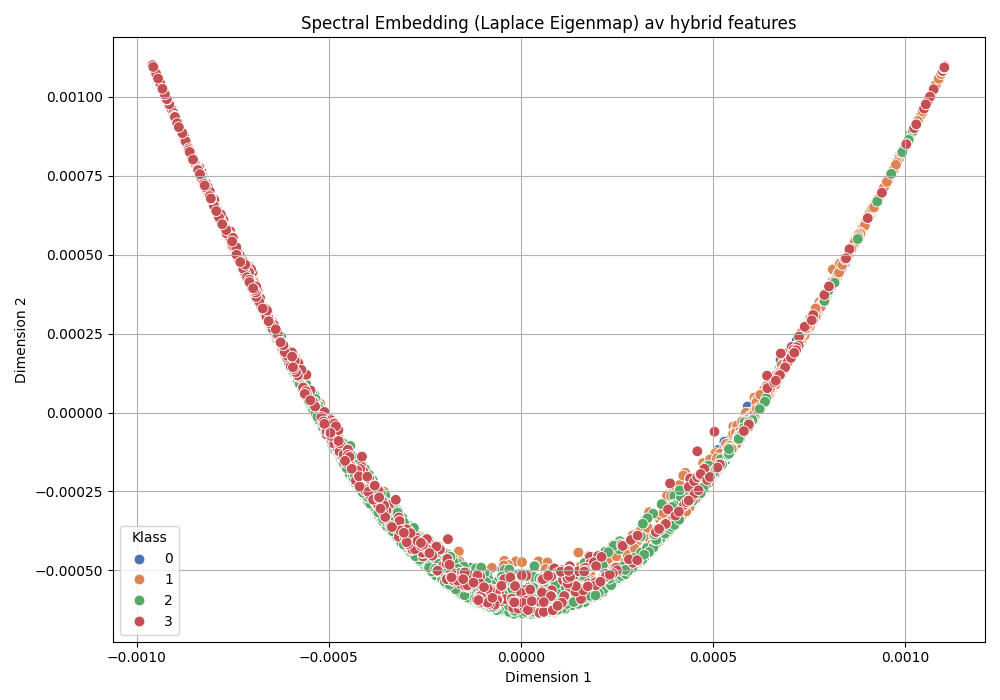

In [35]:
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import seaborn as sns

# Använd X_train och y_train (eller byt till X_test/y_test om du vill)
X_vis = X_train
y_vis = y_train

# Laplacian Eigenmap / Spectral Embedding
spectral = SpectralEmbedding(n_components=4, n_neighbors=500, random_state=42)
X_spec = spectral.fit_transform(X_vis)

# Plotta
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_spec[:, 0], y=X_spec[:, 1], hue=y_vis, palette="deep", s=60)
plt.title("Spectral Embedding (Laplace Eigenmap) av hybrid features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Klass", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


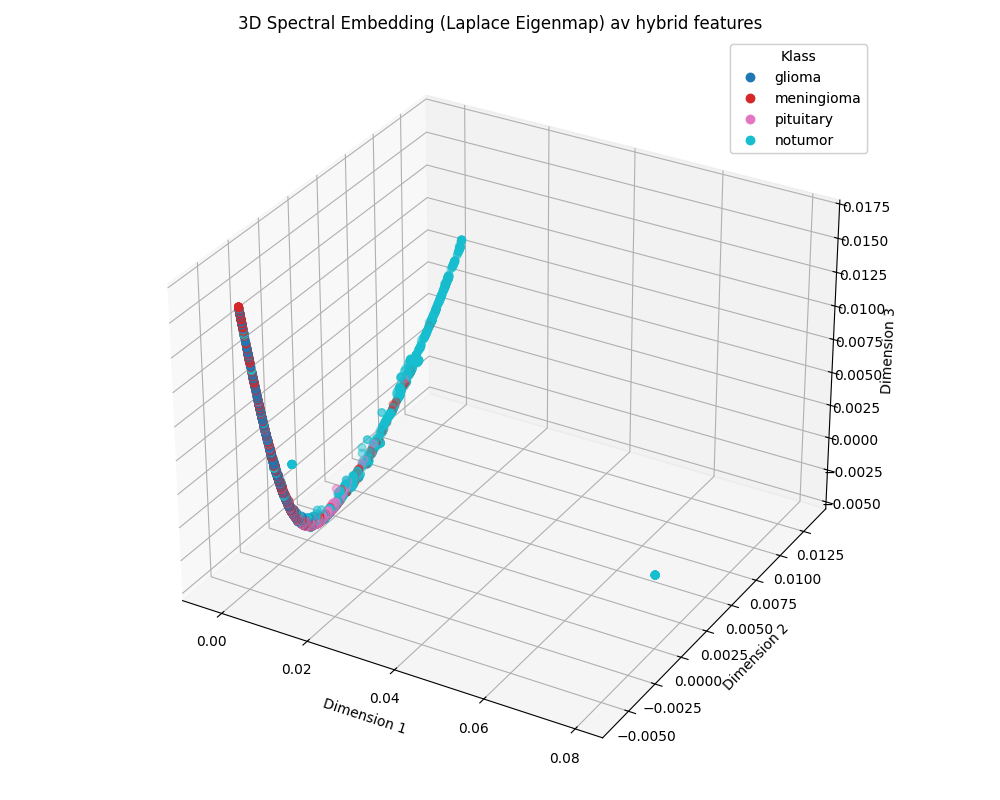

In [37]:
%matplotlib ipympl
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Inputdata
X_vis = X_train
y_vis = y_train

# Laplacian Eigenmap (Spectral Embedding) i 3D
spectral = SpectralEmbedding(n_components=3, n_neighbors=10, random_state=42)
X_spec = spectral.fit_transform(X_vis)

# 3D-plott
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_spec[:, 0], X_spec[:, 1], X_spec[:, 2], c=y_vis, cmap='tab10', s=30)

# Snygg etikettering
ax.set_title("3D Spectral Embedding (Laplace Eigenmap) av hybrid features")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

# Skapa legend-data först
handles, _ = scatter.legend_elements()

# Skapa legend med labels korrekt angivna
legend = ax.legend(handles=handles, labels=legend_labels, title="Klass", loc="upper right")
ax.add_artist(legend)


plt.tight_layout()
plt.show()


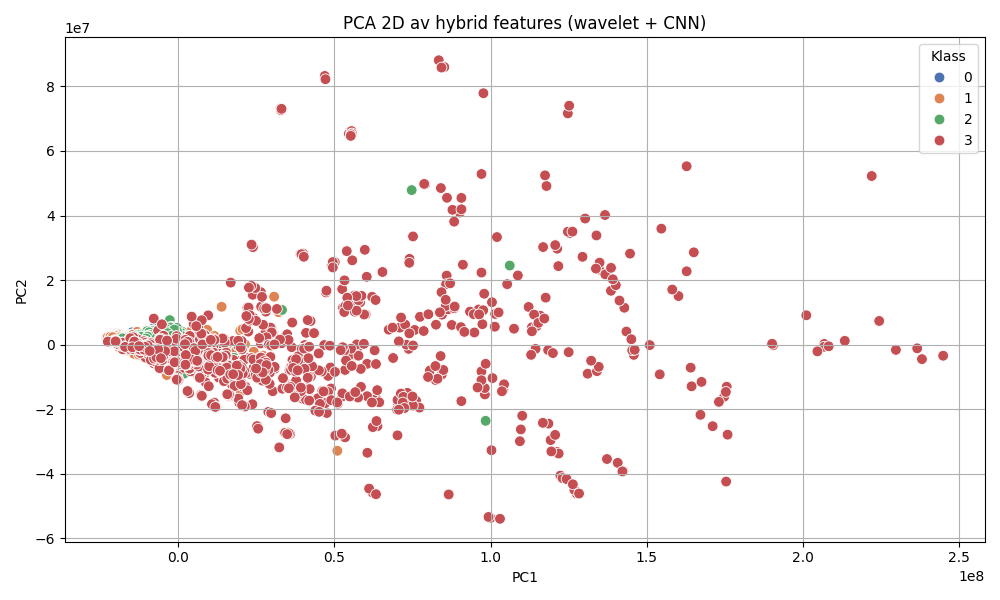

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca_2d = PCA(n_components=50)
X_pca_2d = pca_2d.fit_transform(X_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y_train, palette="deep", s=60)
plt.title("PCA 2D av hybrid features (wavelet + CNN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Klass")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    def encode(self, x):
        return self.encoder(x)


In [20]:
model = Autoencoder(input_dim=X_hybrid.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_tensor = torch.tensor(X_hybrid, dtype=torch.float32).to(device)

# Träna autoencoder
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Extrahera bottleneck-representation
model.eval()
with torch.no_grad():
    X_encoded = model.encode(X_tensor).cpu().numpy()


Epoch 0, Loss: 59217367040.0000
Epoch 10, Loss: 45581656064.0000
Epoch 20, Loss: 15040483328.0000
Epoch 30, Loss: 8541699072.0000
Epoch 40, Loss: 6572021248.0000
Epoch 50, Loss: 5786333184.0000
Epoch 60, Loss: 5598027264.0000
Epoch 70, Loss: 5493671936.0000
Epoch 80, Loss: 5462253568.0000
Epoch 90, Loss: 5447023616.0000


In [28]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Simulerad hybrid feature data (i verkligheten: X_hybrid, y)
from sklearn.datasets import make_classification
X_hybrid, y = make_classification(n_samples=1000, n_features=200, n_classes=4, n_informative=50, random_state=42)

# Autoencoder-modell
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    def encode(self, x):
        return self.encoder(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_hybrid, dtype=torch.float32).to(device)

model = Autoencoder(input_dim=X_hybrid.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Träna autoencoder
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()

# Extrahera kodad representation
model.eval()
with torch.no_grad():
    X_encoded = model.encode(X_tensor).cpu().numpy()

# Träna XGBoost på encoded features
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.2, random_state=42)
clf = XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Klassificeringsrapport
report = classification_report(y_test, y_pred, output_dict=False)
print(report)


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:12:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.83      0.69      0.75        51
           1       0.63      0.78      0.70        49
           2       0.62      0.68      0.65        50
           3       0.67      0.58      0.62        50

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.69      0.68      0.68       200



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y, stratify=y, test_size=0.2)

clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


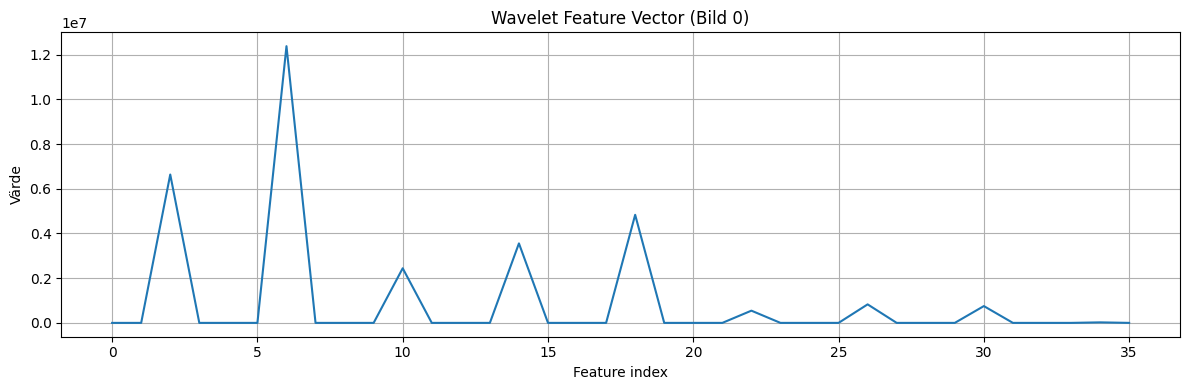

In [10]:
import matplotlib.pyplot as plt

i = 0  # välj vilken bild
plt.figure(figsize=(12, 4))
plt.plot(X[i])
plt.title(f"Wavelet Feature Vector (Bild {i})")
plt.xlabel("Feature index")
plt.ylabel("Värde")
plt.grid(True)
plt.tight_layout()
plt.show()


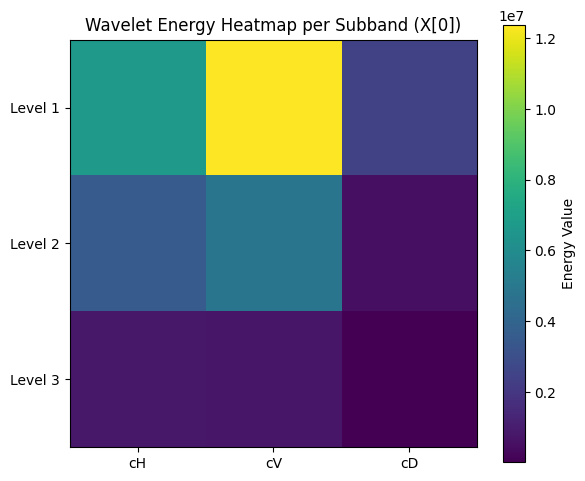

In [13]:
import matplotlib.pyplot as plt

# Förbered indexmappning och etiketter
def get_energy_feature_indices():
    indices = []
    labels = []
    for level in range(1, 4):
        for band in ['cH', 'cV', 'cD']:
            idx = ((level - 1) * 3 + ['cH', 'cV', 'cD'].index(band)) * 4 + 2  # energy ligger alltid på offset 2
            indices.append(idx)
            labels.append(f"Energy_{band}_L{level}")
    return indices, labels

# Extrahera energi-features från en bild
x = X[0]
energy_indices, energy_labels = get_energy_feature_indices()
energy_values = [x[i] for i in energy_indices]

# Omforma till 3x3 grid: nivåer vs riktningar
energy_matrix = np.array(energy_values).reshape((3, 3))  # nivå 1–3 som rader, riktning som kolumner

# Rita heatmap
plt.figure(figsize=(6, 5))
plt.imshow(energy_matrix, cmap='viridis')
plt.xticks(ticks=[0, 1, 2], labels=['cH', 'cV', 'cD'])
plt.yticks(ticks=[0, 1, 2], labels=['Level 1', 'Level 2', 'Level 3'])
plt.title("Wavelet Energy Heatmap per Subband (X[0])")
plt.colorbar(label="Energy Value")
plt.tight_layout()
plt.show()


In [ ]:
# Vi använder wavedec2 igen för att få tillgång till subbanden (ej bara statistik)
coeffs = pywt.wavedec2(images[0], wavelet='db2', level=3)

# Samla alla cH, cV, cD för nivå 1–3
subbands = []
titles = []
for level_num, level in enumerate(coeffs[1:], start=1):
    for band_type, band in zip(['cH', 'cV', 'cD'], level):
        subbands.append(np.abs(band))  # ta absolutvärde för visualisering
        titles.append(f"{band_type} - Level {level_num}")

# Skapa 3x3 grid = 9 bilder = 3 nivåer * 3 riktningar
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(subbands[i], cmap='viridis')
    ax.set_title(titles[i])
    ax.axis('off')

plt.suptitle("Wavelet Subbands (9 st) från Originalbild", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NameError: name 'images' is not defined

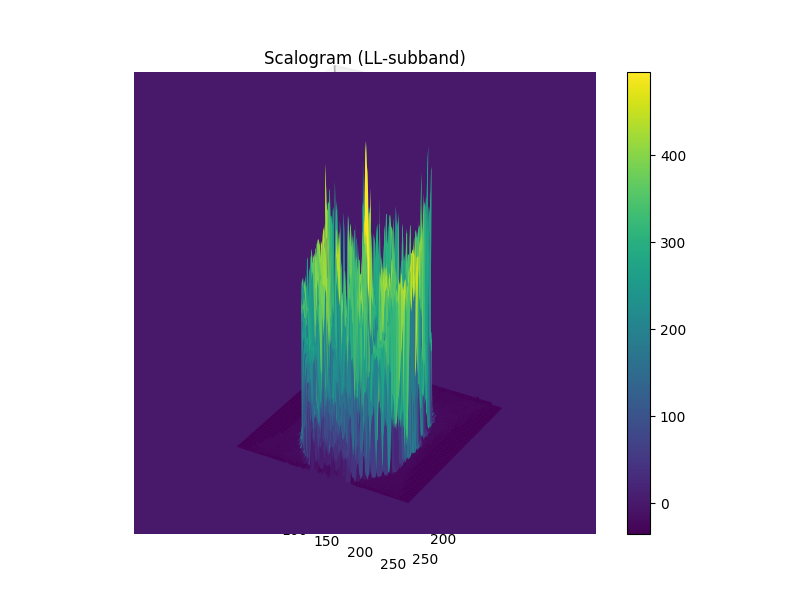

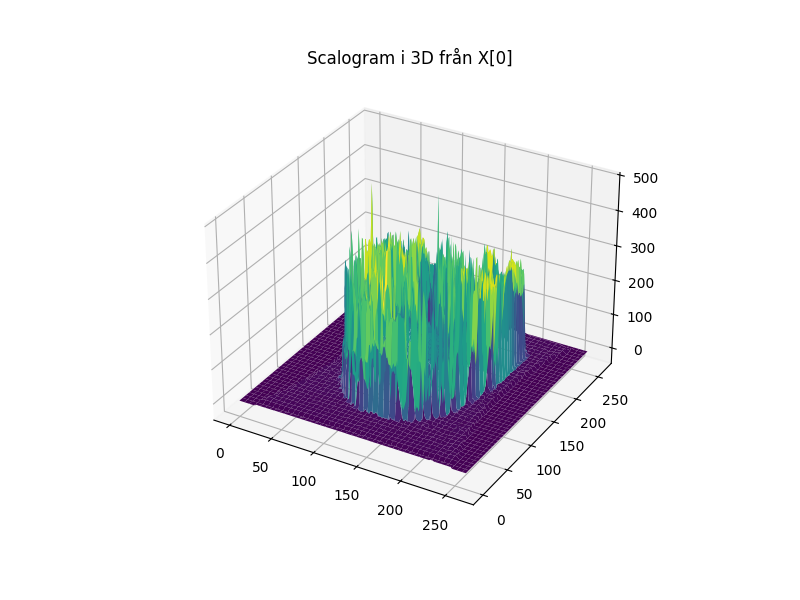

In [35]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Återställ till 2D (du måste veta originalstorlek)
scalo_2d = X[0]

# 📊 2D scalogram (vanlig bild)
plt.imshow(scalo_2d, cmap='viridis')
plt.title("Scalogram (LL-subband)")
plt.colorbar()
plt.show()

# 🧱 3D scalogram
Xgrid, Ygrid = np.meshgrid(np.arange(scalo_2d.shape[1]), np.arange(scalo_2d.shape[0]))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xgrid, Ygrid, scalo_2d, cmap='viridis')
ax.set_title("Scalogram i 3D från X[0]")
plt.show()


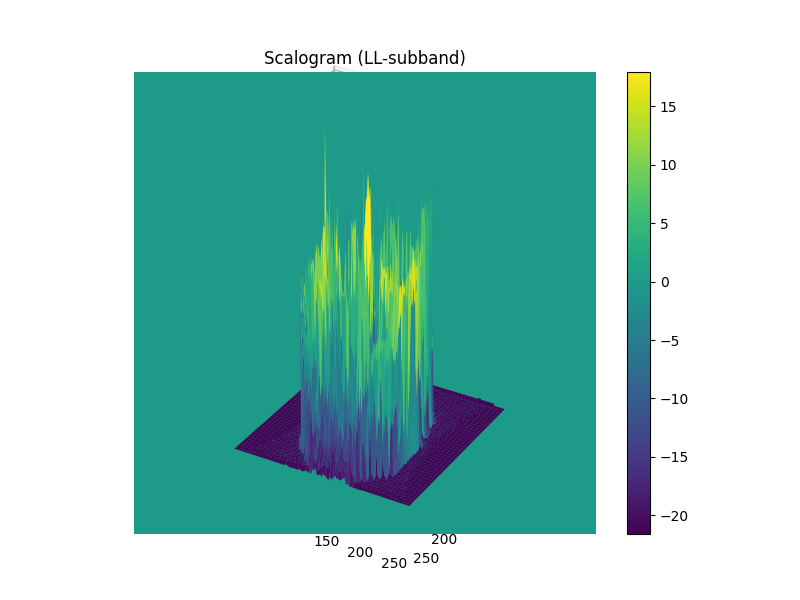

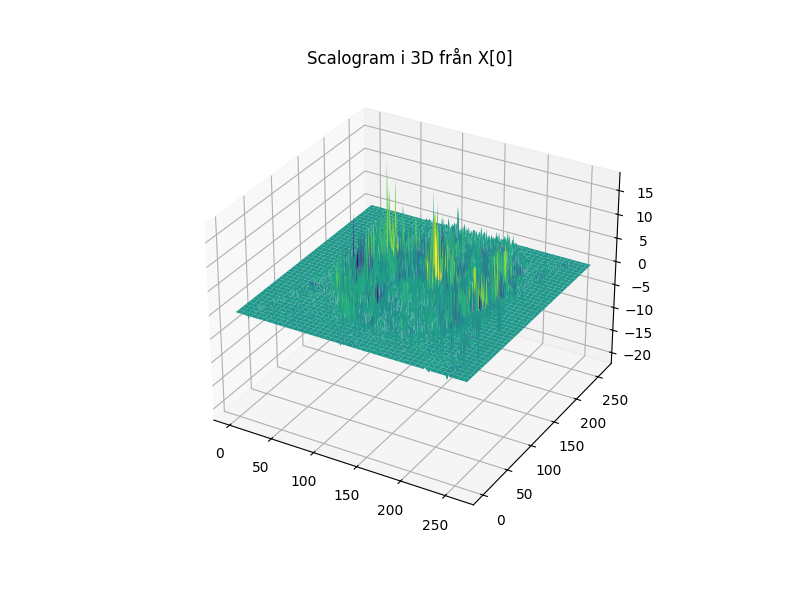

In [36]:
%matplotlib ipympl

# Återställ till 2D (du måste veta originalstorlek)
scalo_2d = LH[0]

# 📊 2D scalogram (vanlig bild)
plt.imshow(scalo_2d, cmap='viridis')
plt.title("Scalogram (LL-subband)")
plt.colorbar()
plt.show()

# 🧱 3D scalogram
Xgrid, Ygrid = np.meshgrid(np.arange(scalo_2d.shape[1]), np.arange(scalo_2d.shape[0]))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xgrid, Ygrid, scalo_2d, cmap='viridis')
ax.set_title("Scalogram i 3D från X[0]")
plt.show()


C:\Users\Rando\AppData\Local\Temp\ipykernel_12196\2964301790.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))


ValueError: 'c' argument has 5712 elements, which is inconsistent with 'x' and 'y' with size 1502256.

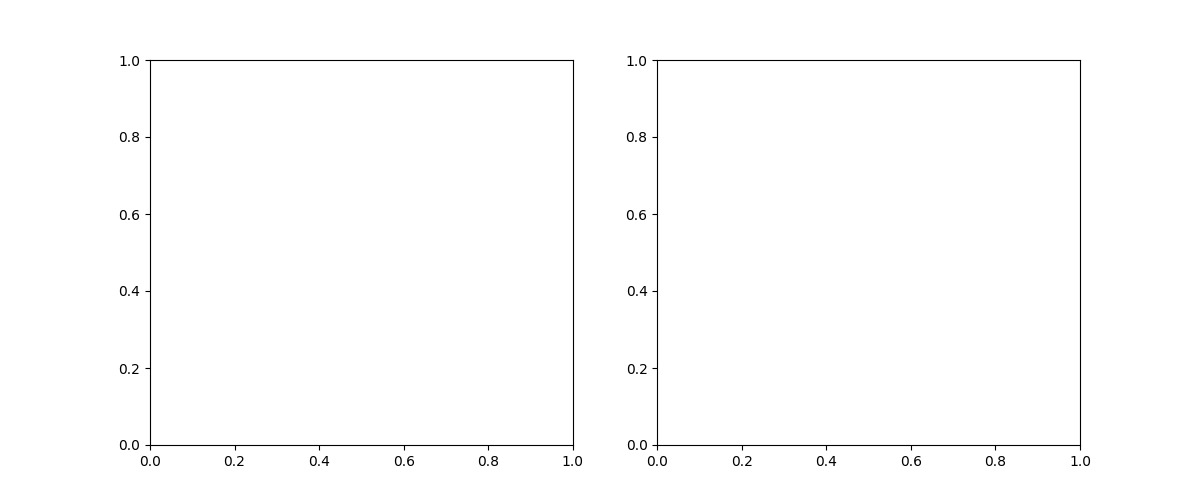

In [56]:
# Skapa Spectral Embedding (Laplacian Eigenmaps)
X_flattened = X.reshape((X.shape[0], -1))  # Blir (5712, 69169)
X_flattened = X_flattened

embedding = SpectralEmbedding(n_components=3, affinity='nearest_neighbors')
X_transformed = embedding.fit_transform(X_flattened)

# Visualisera originaldata och inbäddning
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Original data
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Original Data (2D)")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")

# Efter Spectral Embedding
axs[1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
axs[1].set_title("Spectral Embedding (Laplacian)")
axs[1].set_xlabel("Dim 1")
axs[1].set_ylabel("Dim 2")

plt.figure(figsize=(6, 5))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, s=5)
plt.title("Spectral Embedding (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()
               
plt.tight_layout()
plt.show()


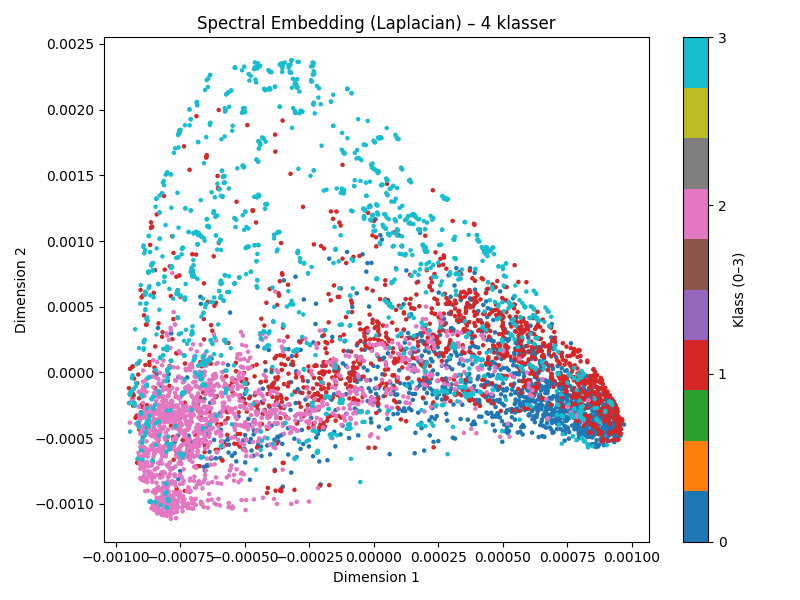

In [63]:
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding

# Platta bilderna: (5712, 263, 263) → (5712, 69169)
X_flattened = X.reshape((X.shape[0], -1))

# Skapa embedding
embedding = SpectralEmbedding(n_components=4, n_neighbors=500)
X_transformed = embedding.fit_transform(X_flattened)

# Visualisera resultatet i 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='tab10', s=5)
plt.title("Spectral Embedding (Laplacian) – 4 klasser")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Klass (0–3)', ticks=[0, 1, 2, 3])
plt.tight_layout()
plt.show()


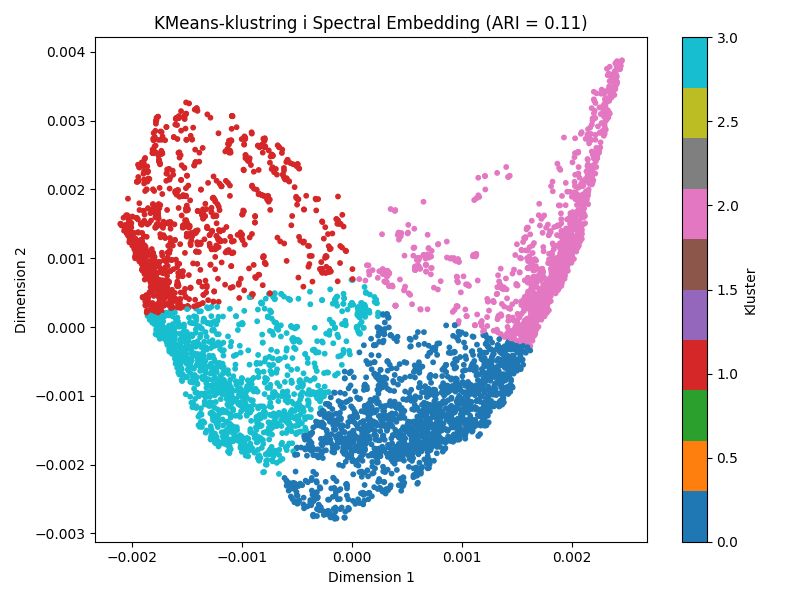

C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       425\n           1       0.00      0.00      0.00       405\n           2       0.00      0.00      0.00       417\n           3       0.27      1.00      0.43       467\n\n    accuracy                           0.27      1714\n   macro avg       0.07      0.25      0.11      1714\nweighted avg       0.07      0.27      0.12      1714\n'

In [67]:
# Återställning kräver att vi importerar om allt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Platta bilder
X_flattened = X.reshape((X.shape[0], -1))
X_flat = X.reshape((X.shape[0], -1))

# Spectral Embedding
embedding = SpectralEmbedding(n_components=2, n_neighbors=100)
X_embedded = embedding.fit_transform(X_flat)

# KMeans-klustring
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X_embedded)

# Mät klustringskvalitet
ari = adjusted_rand_score(y, y_kmeans)

# Klassificering
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Visualisering
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_kmeans, cmap='tab10', s=10)
plt.title(f"KMeans-klustring i Spectral Embedding (ARI = {ari:.2f})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Kluster")
plt.tight_layout()
plt.show()

# Rapport
report = classification_report(y_test, y_pred, output_dict=False)
report


In [68]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.linalg import eigh



# Platta bilder: (n_samples, height*width)
X_flat = X.reshape((X.shape[0], -1))

# Dela upp i träning och test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, random_state=42)

# Steg 2: Bygg kernel (likhetsmatris) på träning
gamma = 1e-3
K_train = rbf_kernel(X_train, X_train, gamma=gamma)  # shape (n_train, n_train)

# Steg 3: Skapa normaliserad Laplacian: L = I - D^{-1/2} K D^{-1/2}
D_train = np.diag(K_train.sum(axis=1))
D_inv_sqrt = np.diag(1.0 / np.sqrt(K_train.sum(axis=1) + 1e-10))
L = np.identity(K_train.shape[0]) - D_inv_sqrt @ K_train @ D_inv_sqrt

# Steg 4: Egenvektorer av Laplacian
eigvals, eigvecs = eigh(L)
X_train_embedded = eigvecs[:, 1:4]  # Hoppa över första (trivial) eigenvektor

# Steg 5: Nyström-approximation för testdata
K_test = rbf_kernel(X_test, X_train, gamma=gamma)  # shape (n_test, n_train)
D_test = np.sum(K_test, axis=1)
D_test_inv_sqrt = 1.0 / np.sqrt(D_test + 1e-10)

X_test_embedded = (K_test @ eigvecs[:, 1:4]) * D_test_inv_sqrt[:, np.newaxis]

# Steg 6: Träna och testa klassificerare
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embedded, y_train)
y_pred = clf.predict(X_test_embedded)

# Rapport
report = classification_report(y_test, y_pred, output_dict=False)
report


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       425\n           1       0.00      0.00      0.00       405\n           2       0.00      0.00      0.00       417\n           3       0.27      1.00      0.43       467\n\n    accuracy                           0.27      1714\n   macro avg       0.07      0.25      0.11      1714\nweighted avg       0.07      0.27      0.12      1714\n'

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Samma som innan: RBF-kernel och Laplacian på träning
gamma = 1e-3
K_train = rbf_kernel(X_train, X_train, gamma=gamma)
D_train = np.diag(K_train.sum(axis=1))
D_inv_sqrt = np.diag(1.0 / np.sqrt(K_train.sum(axis=1) + 1e-10))
L = np.identity(K_train.shape[0]) - D_inv_sqrt @ K_train @ D_inv_sqrt

# Egenvektorer (top 10, hoppa över första)
eigvals, eigvecs = eigh(L)
X_train_embedded = eigvecs[:, 1:11]  # top 10 (förbättrad representation)

# Nyström-projicera testdata
K_test = rbf_kernel(X_test, X_train, gamma=gamma)
D_test = np.sum(K_test, axis=1)
D_test_inv_sqrt = 1.0 / np.sqrt(D_test + 1e-10)
X_test_embedded = (K_test @ eigvecs[:, 1:11]) * D_test_inv_sqrt[:, np.newaxis]

# Random Forest klassificerare
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embedded, y_train)
y_pred = clf.predict(X_test_embedded)

# Ny rapport utan varningar
report_rf = classification_report(y_test, y_pred, zero_division=0, output_dict=False)
report_rf

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       425\n           1       0.00      0.00      0.00       405\n           2       0.25      1.00      0.40       417\n           3       1.00      0.13      0.22       467\n\n    accuracy                           0.28      1714\n   macro avg       0.31      0.28      0.16      1714\nweighted avg       0.33      0.28      0.16      1714\n'

In [79]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# PCA istället för Laplacian embedding
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Träna en Random Forest-klassificerare
clf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

# Klassificeringsrapport
report_pca = classification_report(y_test, y_pred_pca, zero_division=0, output_dict=True)
report_pca = pd.DataFrame(report_pca)
report_pca

0           1           2           3  accuracy  \
precision    0.873134    0.796482    0.908686    0.939785   0.88273   
recall       0.825882    0.782716    0.978417    0.935760   0.88273   
f1-score     0.848851    0.789539    0.942263    0.937768   0.88273   
support    425.000000  405.000000  417.000000  467.000000   0.88273   

             macro avg  weighted avg  
precision     0.879522      0.881831  
recall        0.880694      0.882730  
f1-score      0.879606      0.881789  
support    1714.000000   1714.000000

In [82]:
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Isomap-inbäddning till 20 dimensioner
isomap = Isomap(n_components=100, n_neighbors=100)
X_train_iso = isomap.fit_transform(X_train)
X_test_iso = isomap.transform(X_test)

# Random Forest klassificerare
clf_iso = RandomForestClassifier(n_estimators=100, random_state=42)
clf_iso.fit(X_train_iso, y_train)
y_pred_iso = clf_iso.predict(X_test_iso)

# Klassificeringsrapport
report_iso = classification_report(y_test, y_pred_iso, zero_division=0, output_dict=True)
report_iso = pd.DataFrame(report_iso)
report_iso


0           1           2           3  accuracy  \
precision    0.776744    0.755376    0.863341    0.935698  0.837223   
recall       0.785882    0.693827    0.954436    0.903640  0.837223   
f1-score     0.781287    0.723295    0.906606    0.919390  0.837223   
support    425.000000  405.000000  417.000000  467.000000  0.837223   

             macro avg  weighted avg  
precision     0.832790      0.836072  
recall        0.834447      0.837223  
f1-score      0.832644      0.835701  
support    1714.000000   1714.000000

In [ ]:
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Anta att du har data X (t.ex. bilder) och y (klasser)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# UMAP-inbäddning
umap_model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42)
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

# Klassificering
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_umap, y_train)
y_pred = clf.predict(X_test_umap)

# Utvärdera
print(classification_report(y_test, y_pred, zero_division=0))


In [85]:
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_flat = X.reshape((X.shape[0], -1))

# Anta att du har data X (t.ex. bilder) och y (klasser)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, random_state=42)

# UMAP-inbäddning
umap_model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42)
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

# Klassificering
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_umap, y_train)
y_pred = clf.predict(X_test_umap)

# Utvärdera
print(classification_report(y_test, y_pred, zero_division=0))


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Ladda data
X_flat = X.reshape((X.shape[0], -1))


# Träna UMAP
mapper = umap.UMAP(n_components=2, random_state=42).fit(X_flat)

# Plot med etiketter
umap.plot.points(mapper, labels=y, theme='fire')  # theme='viridis', 'fire', 'blue', etc.
plt.title("UMAP av Digits Dataset")
plt.show()


C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
C:\Users\Rando\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [1]:
del X_test_umap, X_train, X_test
import gc
gc.collect()

NameError: name 'X_test_umap' is not defined